=== 10-FOLD ROC AUC SCORES ===
GBM: Mean = 0.8467 | Std = 0.0054
XGBoost: Mean = 0.8221 | Std = 0.0100
RandomForest: Mean = 0.8221 | Std = 0.0083
LogisticRegression: Mean = 0.8450 | Std = 0.0043
SVC: Mean = 0.7987 | Std = 0.0112
NeuralNet: Mean = 0.7907 | Std = 0.0141
AdaBoost: Mean = 0.8479 | Std = 0.0053

=== WILCOXON SIGNED-RANK TEST (GBM vs Others) ===
XGBoost: p-value = 0.0020
RandomForest: p-value = 0.0020
LogisticRegression: p-value = 0.5566
SVC: p-value = 0.0020
NeuralNet: p-value = 0.0020
AdaBoost: p-value = 0.5566

=== FINAL GBM EVALUATION ===
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1033
        True       0.64      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC: 0.8406619005958451

=== SHAP EXPLANATION ===


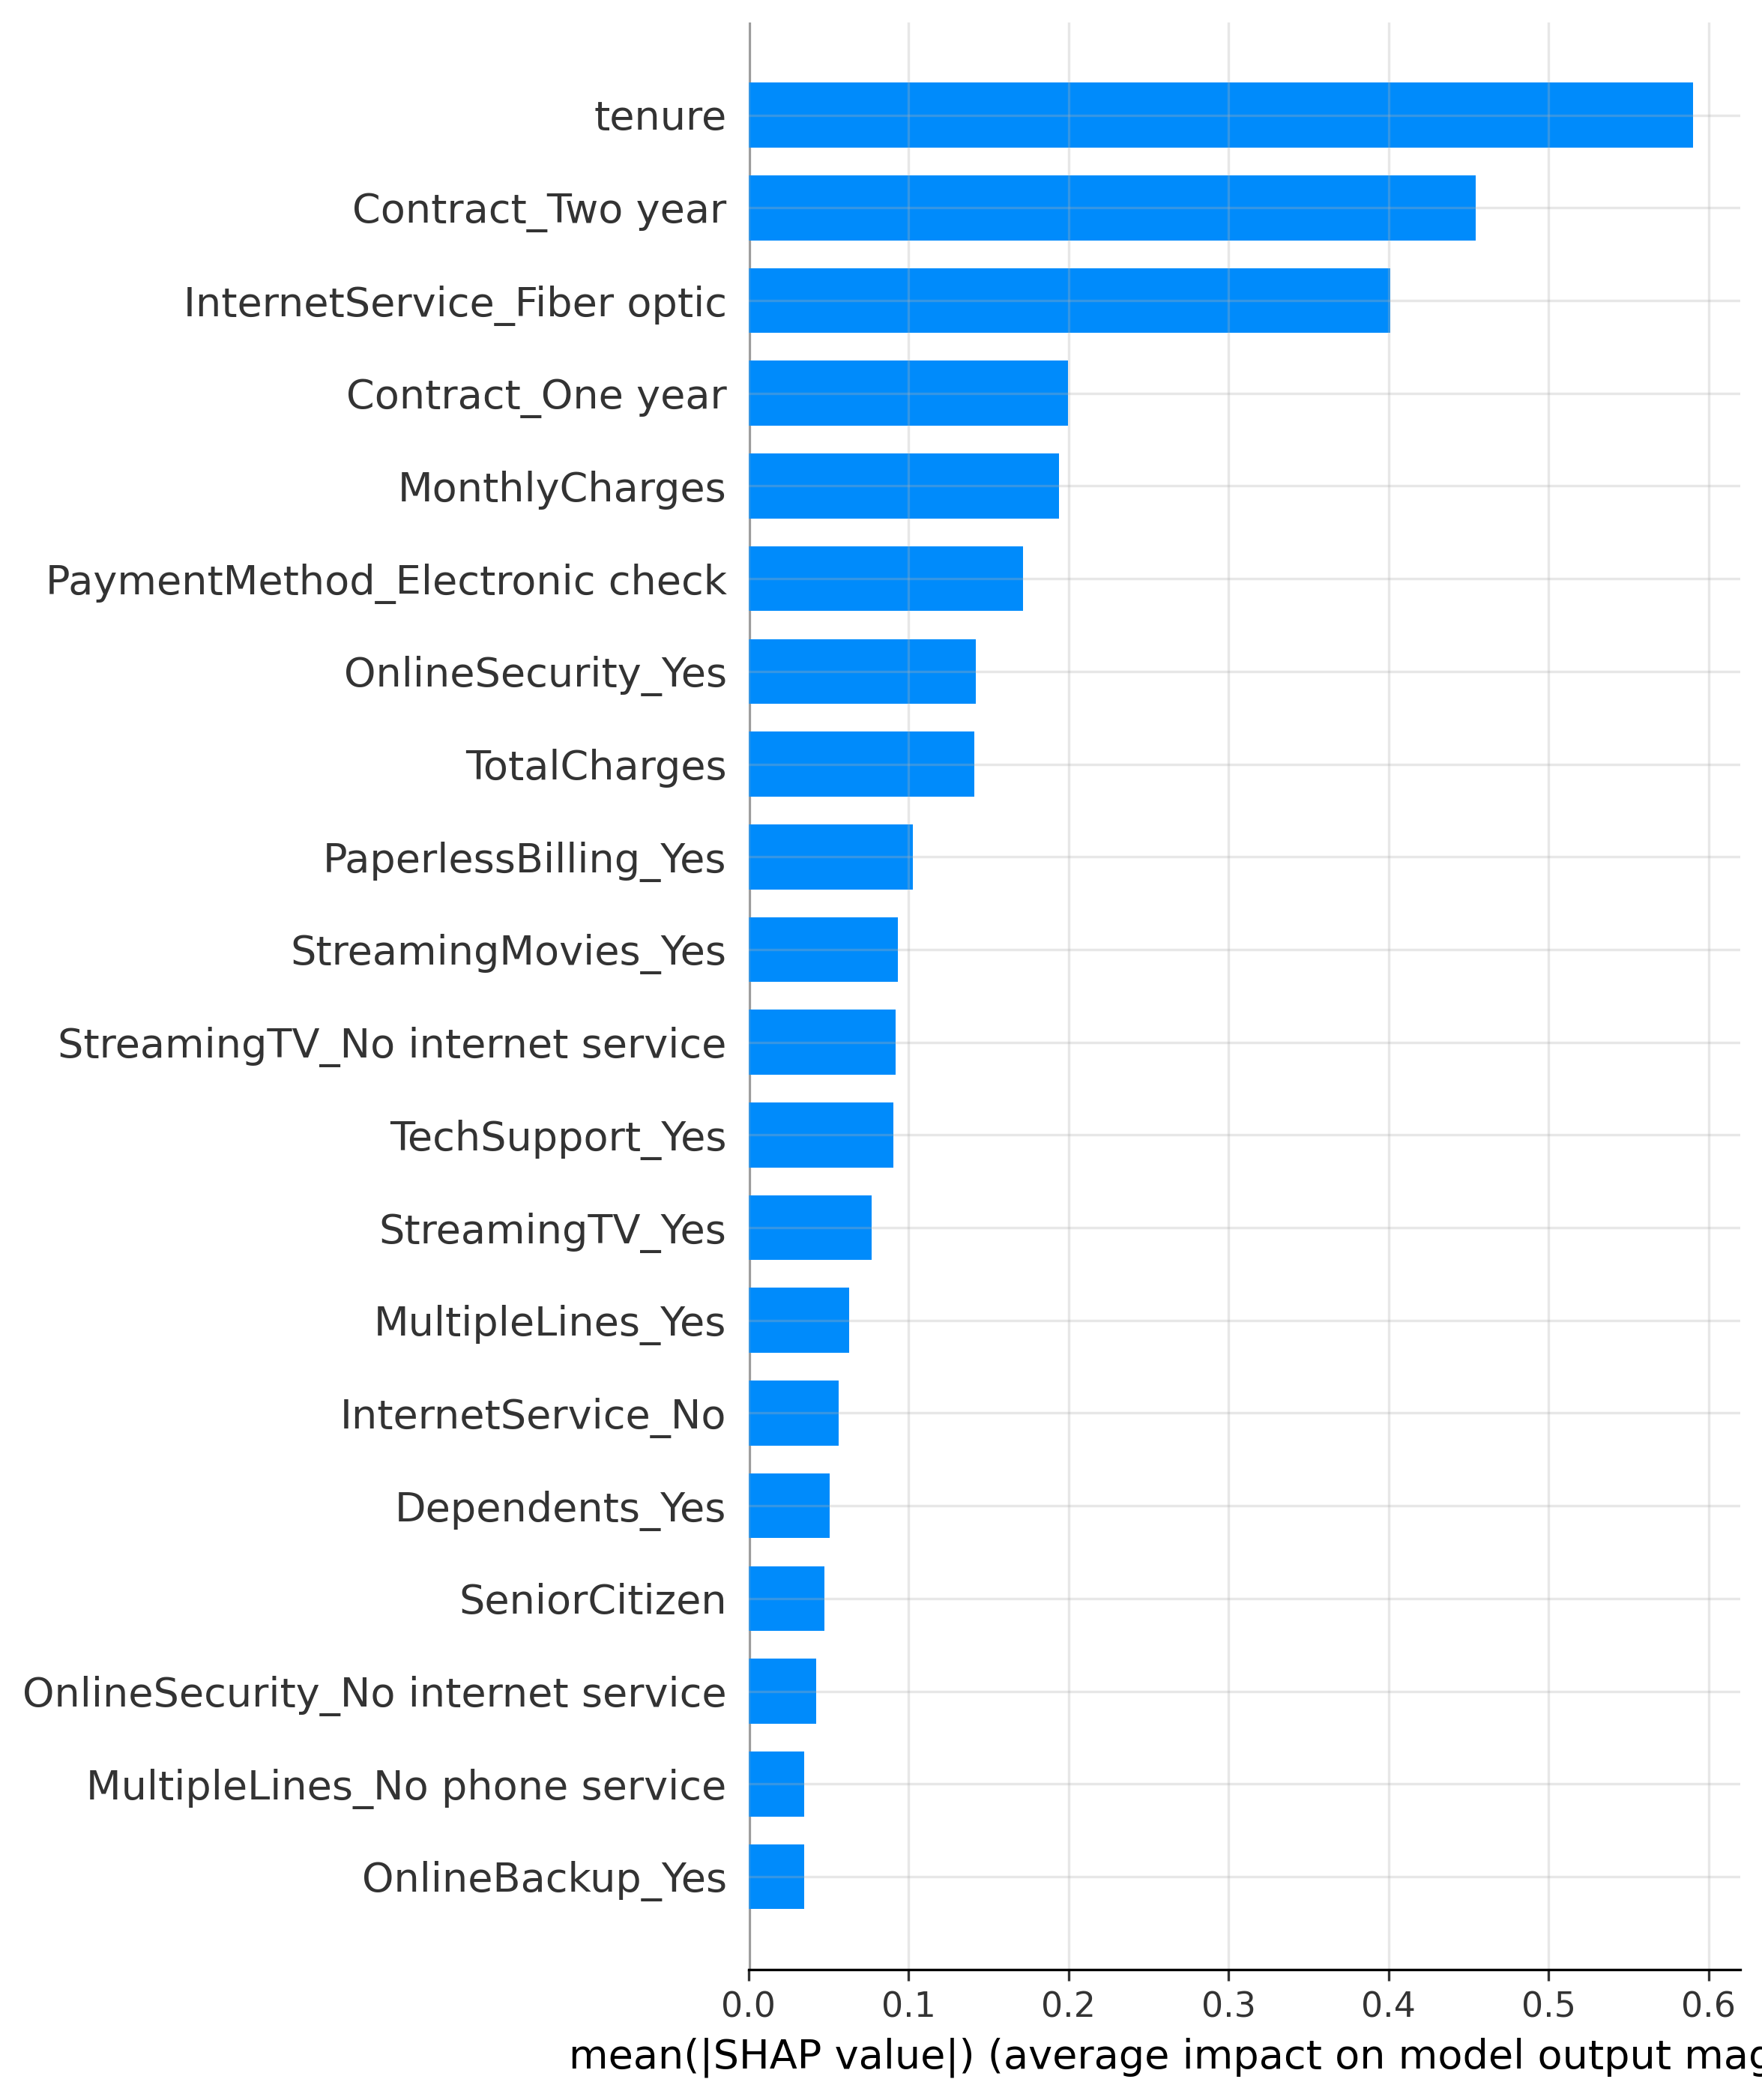

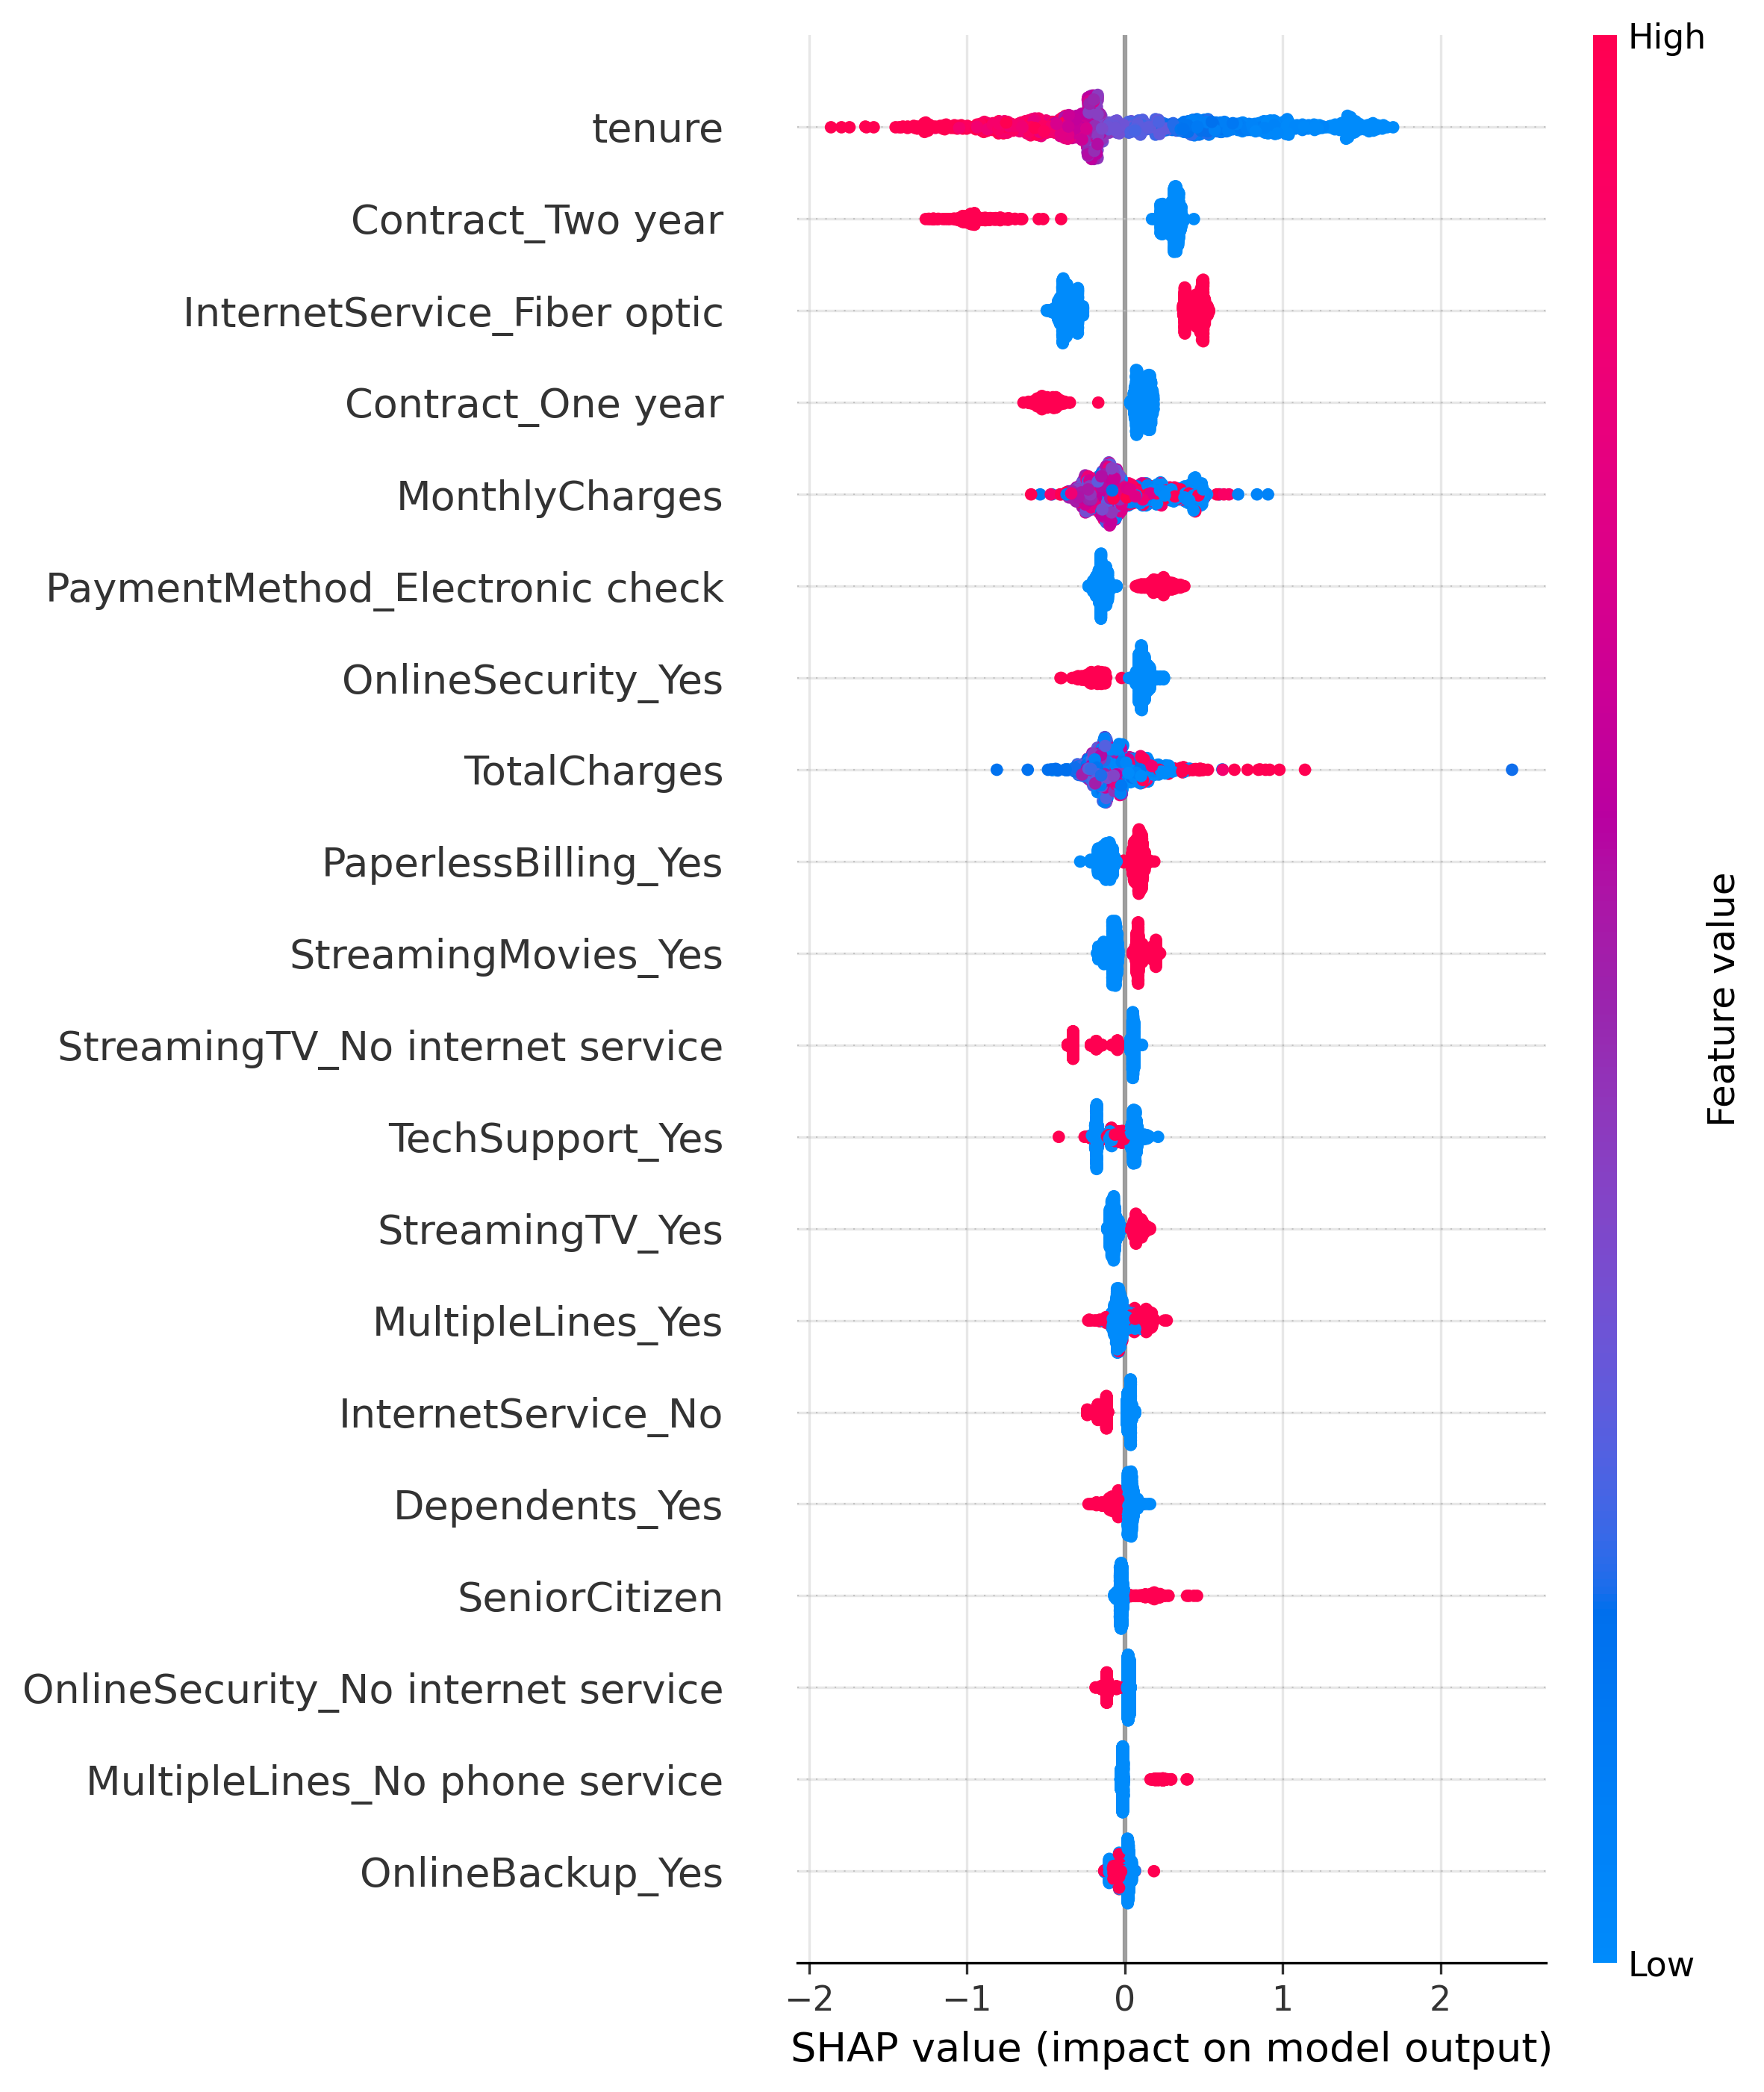

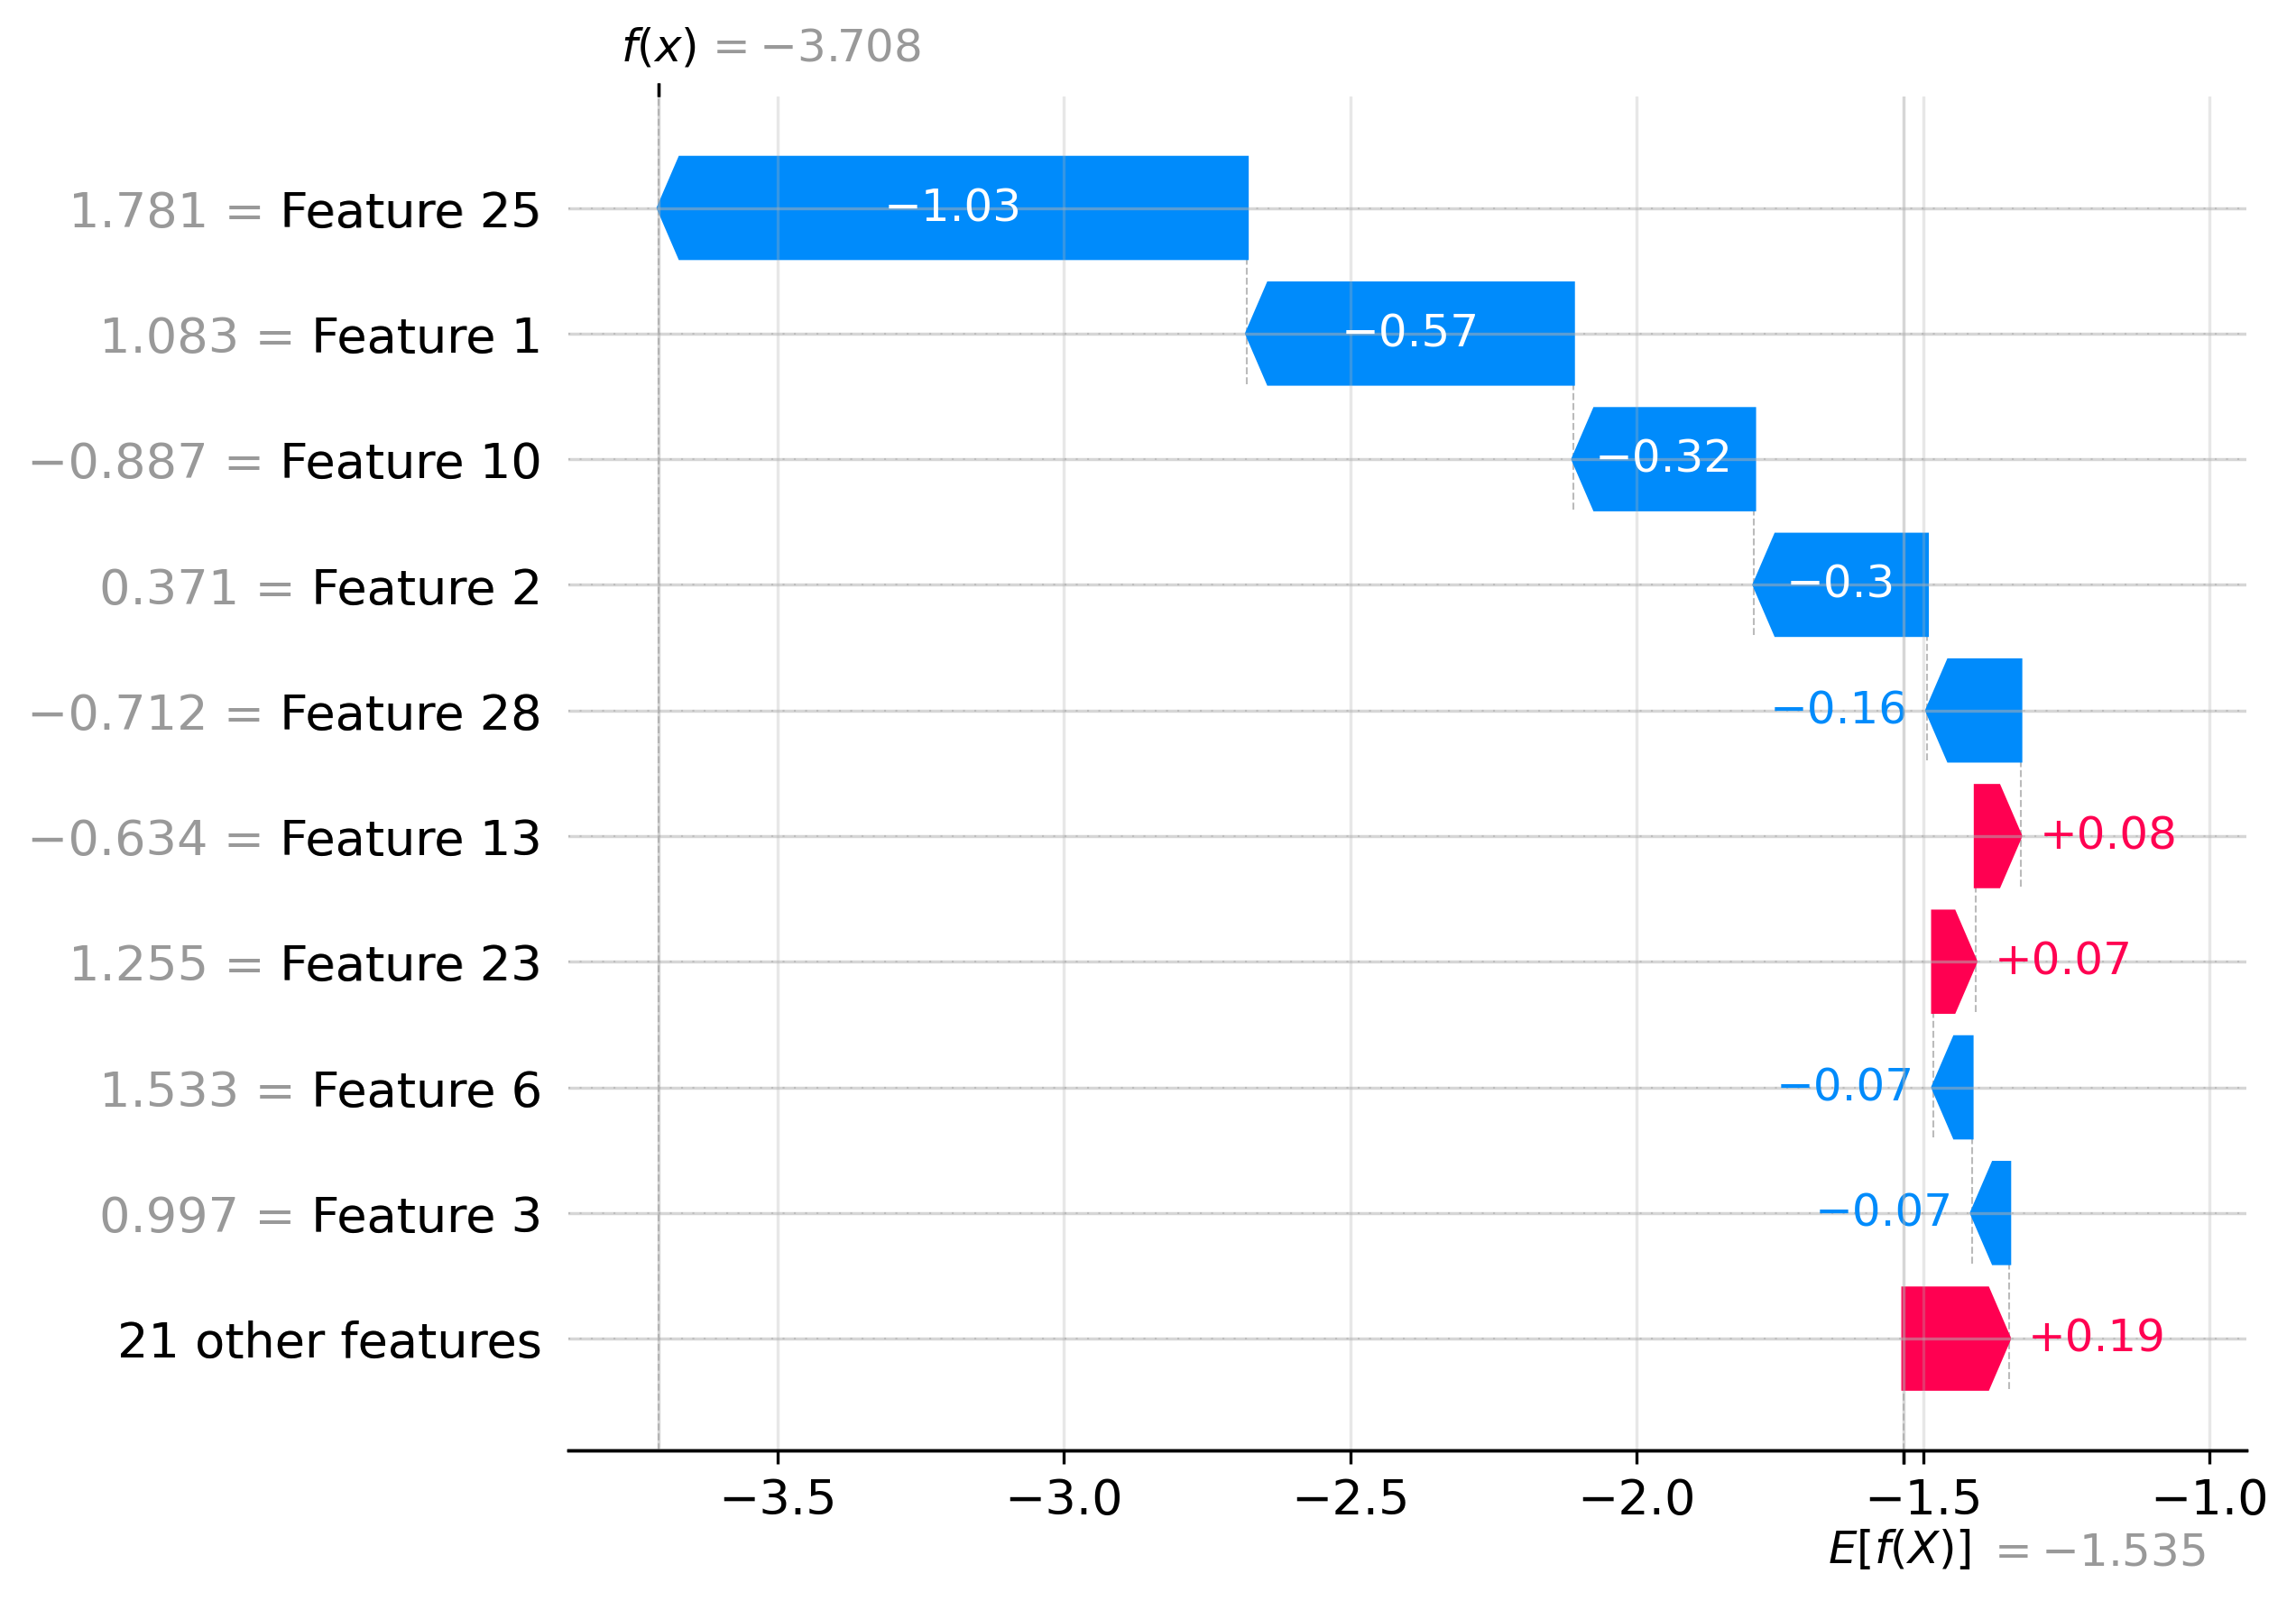

In [4]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import wilcoxon

# === STEP 1: LOAD DATASET ===
df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# === STEP 2: NORMALISASI KOLOM ===
df.columns = df.columns.str.strip().str.replace(" ", "_")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(['customerID'], axis=1, errors='ignore', inplace=True)

# === STEP 3: ENCODING ===
df = pd.get_dummies(df, drop_first=True)

# === STEP 4: SPLIT FITUR & LABEL ===
X = df.drop("Churn_Yes", axis=1)
y = df["Churn_Yes"]

# === STEP 5: SCALING ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === STEP 6: SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# === STEP 7: DEFINISI MODEL ===
models = {
    "GBM": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "NeuralNet": MLPClassifier(max_iter=1000, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
roc_results = {}

print("=== 10-FOLD ROC AUC SCORES ===")
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    roc_results[name] = scores
    print(f"{name}: Mean = {scores.mean():.4f} | Std = {scores.std():.4f}")

# === STEP 8: WILCOXON TEST (vs GBM) ===
print("\n=== WILCOXON SIGNED-RANK TEST (GBM vs Others) ===")
gbm_scores = roc_results["GBM"]
for name, scores in roc_results.items():
    if name != "GBM":
        stat, p = wilcoxon(gbm_scores, scores)
        print(f"{name}: p-value = {p:.4f}")

# === STEP 9: FINAL GBM TRAINING ===
final_model = GradientBoostingClassifier(random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("\n=== FINAL GBM EVALUATION ===")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]))

# === STEP 10: SHAP ===
print("\n=== SHAP EXPLANATION ===")
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=pd.DataFrame(X_test, columns=X.columns), plot_type="bar")
shap.summary_plot(shap_values, features=pd.DataFrame(X_test, columns=X.columns))
shap.plots.waterfall(shap_values[0])


In [3]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')

def setup_directories():
    """Create necessary directories for results"""
    result_dir = Path("final_result")
    result_dir.mkdir(exist_ok=True)
    return result_dir

def setup_plot_style():
    """Setup matplotlib style for publication-quality plots"""
    plt.style.use('default')
    plt.rcParams.update({
        'figure.figsize': (10, 6),
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.facecolor': 'white',
        'axes.grid': True,
        'grid.alpha': 0.3
    })

def load_and_preprocess_data(filepath):
    """Load and preprocess the dataset"""
    print("Loading and preprocessing data...")

    # Load dataset
    df = pd.read_csv(filepath)

    # Normalize column names
    df.columns = df.columns.str.strip().str.replace(" ", "_")

    # Handle TotalCharges conversion
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Drop rows with missing values
    initial_rows = len(df)
    df.dropna(inplace=True)
    print(f"Removed {initial_rows - len(df)} rows with missing values")

    # Drop customerID
    df.drop(['customerID'], axis=1, errors='ignore', inplace=True)

    # One-hot encoding
    df_encoded = pd.get_dummies(df, drop_first=True)

    return df_encoded

def create_data_overview_plots(df, result_dir):
    """Create data overview and EDA plots"""
    print("Creating data overview plots...")

    # Target distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Churn distribution
    churn_counts = df['Churn_Yes'].value_counts()
    axes[0].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
                colors=['lightblue', 'lightcoral'])
    axes[0].set_title('Customer Churn Distribution')

    # Churn by tenure
    axes[1].hist([df[df['Churn_Yes']==0]['tenure'], df[df['Churn_Yes']==1]['tenure']],
                bins=20, alpha=0.7, label=['No Churn', 'Churn'], color=['lightblue', 'lightcoral'])
    axes[1].set_xlabel('Tenure (months)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Churn Distribution by Tenure')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(result_dir / 'data_overview.png')
    plt.close()

def train_and_evaluate_models(X_scaled, y):
    """Train multiple models and perform cross-validation"""
    print("Training and evaluating models...")

    # Define models
    models = {
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "Neural Network": MLPClassifier(max_iter=1000, random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42)
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    roc_results = {}

    print("\n=== 10-FOLD CROSS-VALIDATION ROC AUC SCORES ===")
    print("-" * 60)
    for name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
        roc_results[name] = scores
        print(f"{name:<20}: Mean = {scores.mean():.4f} ± {scores.std():.4f}")

    return models, roc_results

def create_model_comparison_plot(roc_results, result_dir):
    """Create model comparison visualization"""
    print("Creating model comparison plot...")

    # Extract data for plotting
    model_names = list(roc_results.keys())
    scores_data = [roc_results[name] for name in model_names]
    means = [np.mean(scores) for scores in scores_data]
    stds = [np.std(scores) for scores in scores_data]

    # Create box plot and bar plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Box plot
    bp = ax1.boxplot(scores_data, labels=model_names, patch_artist=True)
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax1.set_title('Model Performance Distribution (10-Fold CV)')
    ax1.set_ylabel('ROC AUC Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Bar plot with error bars
    x_pos = np.arange(len(model_names))
    bars = ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
    ax2.set_xlabel('Models')
    ax2.set_ylabel('ROC AUC Score')
    ax2.set_title('Model Performance Comparison (Mean ± Std)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.005,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(result_dir / 'model_comparison.png')
    plt.close()

def perform_statistical_tests(roc_results, result_dir):
    """Perform Wilcoxon signed-rank tests"""
    print("\n=== STATISTICAL SIGNIFICANCE TESTS ===")
    print("-" * 50)

    # Use best performing model as baseline
    best_model = max(roc_results.keys(), key=lambda k: np.mean(roc_results[k]))
    print(f"Using {best_model} as baseline for comparison")

    baseline_scores = roc_results[best_model]
    test_results = []

    for name, scores in roc_results.items():
        if name != best_model:
            stat, p_value = wilcoxon(baseline_scores, scores)
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            test_results.append({
                'Model': name,
                'p-value': p_value,
                'Significance': significance
            })
            print(f"{name:<20}: p-value = {p_value:.4f} ({significance})")

    # Create significance test results table
    df_tests = pd.DataFrame(test_results)

    # Save results
    df_tests.to_csv(result_dir / 'statistical_tests.csv', index=False)

    return best_model

def train_final_model(best_model_name, models, X_train, X_test, y_train, y_test, result_dir):
    """Train final model and create evaluation plots"""
    print(f"\n=== TRAINING FINAL {best_model_name.upper()} MODEL ===")
    print("-" * 50)

    # Train final model
    final_model = models[best_model_name]
    final_model.fit(X_train, y_train)

    # Predictions
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Evaluation metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'{best_model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(result_dir / 'confusion_matrix.png')
    plt.close()

    return final_model

def create_shap_analysis(final_model, X_train, X_test, feature_names, result_dir):
    """Create SHAP analysis plots"""
    print("\n=== CREATING SHAP ANALYSIS ===")
    print("-" * 40)

    try:
        # Create SHAP explainer with appropriate method for different models
        model_name = type(final_model).__name__

        if model_name in ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier']:
            # Tree-based models
            explainer = shap.TreeExplainer(final_model)
            shap_values = explainer.shap_values(X_test)

            # For binary classification, use the positive class
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Use positive class

        elif model_name in ['LogisticRegression', 'SVC']:
            # Linear models
            explainer = shap.LinearExplainer(final_model, X_train)
            shap_values = explainer.shap_values(X_test)

        else:
            # For other models (AdaBoost, Neural Networks, etc.)
            explainer = shap.KernelExplainer(final_model.predict_proba, X_train[:100])  # Use subset for efficiency
            shap_values = explainer.shap_values(X_test[:50])  # Limit test samples for efficiency

            # For binary classification, use the positive class
            if isinstance(shap_values, list):
                shap_values = shap_values[1]  # Use positive class

        # Ensure shap_values is 2D array
        if len(shap_values.shape) == 1:
            shap_values = shap_values.reshape(1, -1)

        # Feature importance bar plot
        plt.figure(figsize=(10, 8))
        shap_importance = np.abs(shap_values).mean(axis=0)
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': shap_importance
        }).sort_values('importance', ascending=True)

        plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
        plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('Feature Importance (SHAP Values)')
        plt.tight_layout()
        plt.savefig(result_dir / 'shap_feature_importance.png')
        plt.close()

        # SHAP summary plot
        plt.figure(figsize=(10, 8))
        if model_name in ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier']:
            shap.summary_plot(shap_values,
                             features=pd.DataFrame(X_test, columns=feature_names),
                             show=False)
        else:
            # For models that don't support full summary plot, create a simplified version
            shap.summary_plot(shap_values,
                             features=pd.DataFrame(X_test[:len(shap_values)], columns=feature_names),
                             plot_type="bar",
                             show=False)
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.savefig(result_dir / 'shap_summary.png')
        plt.close()

        # Waterfall plot for first instance (if available)
        if len(shap_values) > 0:
            plt.figure(figsize=(10, 6))
            try:
                if model_name in ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier']:
                    # For tree models, use the new SHAP format
                    explainer_new = shap.Explainer(final_model)
                    shap_values_new = explainer_new(X_test[:1])
                    shap.plots.waterfall(shap_values_new[0], show=False)
                else:
                    # For other models, create a simple bar plot
                    instance_shap = shap_values[0]
                    feature_names_array = np.array(feature_names)
                    sorted_idx = np.argsort(np.abs(instance_shap))[-10:]  # Top 10 features

                    plt.barh(range(len(sorted_idx)), instance_shap[sorted_idx])
                    plt.yticks(range(len(sorted_idx)), feature_names_array[sorted_idx])
                    plt.xlabel('SHAP Value')
                    plt.title('SHAP Values for First Instance (Top 10 Features)')

                plt.tight_layout()
                plt.savefig(result_dir / 'shap_waterfall.png')
                plt.close()
            except Exception as e:
                print(f"Warning: Could not create waterfall plot: {e}")
                # Create alternative feature importance plot for the instance
                plt.figure(figsize=(10, 6))
                instance_shap = shap_values[0]
                feature_names_array = np.array(feature_names)
                sorted_idx = np.argsort(np.abs(instance_shap))[-10:]  # Top 10 features

                colors = ['red' if x < 0 else 'blue' for x in instance_shap[sorted_idx]]
                plt.barh(range(len(sorted_idx)), instance_shap[sorted_idx], color=colors, alpha=0.7)
                plt.yticks(range(len(sorted_idx)), feature_names_array[sorted_idx])
                plt.xlabel('SHAP Value')
                plt.title('SHAP Values for First Instance (Top 10 Features)')
                plt.tight_layout()
                plt.savefig(result_dir / 'shap_waterfall.png')
                plt.close()

        print("SHAP analysis completed and saved.")

    except Exception as e:
        print(f"Warning: SHAP analysis failed: {e}")
        print("Creating alternative feature importance plot using model's built-in feature importance...")

        # Alternative: Use model's built-in feature importance if available
        try:
            if hasattr(final_model, 'feature_importances_'):
                plt.figure(figsize=(10, 8))
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': final_model.feature_importances_
                }).sort_values('importance', ascending=True)

                plt.barh(range(len(importance_df)), importance_df['importance'])
                plt.yticks(range(len(importance_df)), importance_df['feature'])
                plt.xlabel('Feature Importance')
                plt.title('Feature Importance (Model Built-in)')
                plt.tight_layout()
                plt.savefig(result_dir / 'feature_importance_builtin.png')
                plt.close()
                print("Alternative feature importance plot created.")
            else:
                print("Model does not have built-in feature importance.")
        except Exception as e2:
            print(f"Alternative feature importance also failed: {e2}")

def save_results_summary(roc_results, best_model, result_dir):
    """Save comprehensive results summary"""
    print("\n=== SAVING RESULTS SUMMARY ===")

    # Create summary dataframe
    summary_data = []
    for name, scores in roc_results.items():
        summary_data.append({
            'Model': name,
            'Mean_ROC_AUC': scores.mean(),
            'Std_ROC_AUC': scores.std(),
            'Min_ROC_AUC': scores.min(),
            'Max_ROC_AUC': scores.max(),
            'Is_Best': name == best_model
        })

    df_summary = pd.DataFrame(summary_data)
    df_summary = df_summary.sort_values('Mean_ROC_AUC', ascending=False)

    # Save to CSV
    df_summary.to_csv(result_dir / 'model_performance_summary.csv', index=False)

    # Create formatted summary for publication
    with open(result_dir / 'results_summary.txt', 'w') as f:
        f.write("CUSTOMER CHURN PREDICTION - MODEL COMPARISON RESULTS\n")
        f.write("=" * 60 + "\n\n")
        f.write("Model Performance Ranking (10-Fold Cross-Validation):\n")
        f.write("-" * 50 + "\n")

        for idx, row in df_summary.iterrows():
            f.write(f"{idx+1}. {row['Model']:<20}: {row['Mean_ROC_AUC']:.4f} ± {row['Std_ROC_AUC']:.4f}\n")

        f.write(f"\nBest Model: {best_model}\n")
        f.write(f"Best Performance: {df_summary.iloc[0]['Mean_ROC_AUC']:.4f} ± {df_summary.iloc[0]['Std_ROC_AUC']:.4f}\n")

    print(f"Results summary saved to {result_dir}")

def main():
    """Main execution function"""
    print("CUSTOMER CHURN PREDICTION ANALYSIS")
    print("=" * 50)

    # Setup
    result_dir = setup_directories()
    setup_plot_style()

    # Data preprocessing
    df = load_and_preprocess_data("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")

    # Create overview plots
    create_data_overview_plots(df, result_dir)

    # Prepare features and target
    X = df.drop("Churn_Yes", axis=1)
    y = df["Churn_Yes"]

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, stratify=y, test_size=0.2, random_state=42
    )

    # Model training and evaluation
    models, roc_results = train_and_evaluate_models(X_scaled, y)

    # Create comparison plots
    create_model_comparison_plot(roc_results, result_dir)

    # Statistical tests
    best_model = perform_statistical_tests(roc_results, result_dir)

    # Train final model
    final_model = train_final_model(best_model, models, X_train, X_test, y_train, y_test, result_dir)

    # SHAP analysis
    create_shap_analysis(final_model, X_train, X_test, X.columns, result_dir)

    # Save comprehensive results
    save_results_summary(roc_results, best_model, result_dir)

    print("\n" + "=" * 50)
    print("ANALYSIS COMPLETED SUCCESSFULLY!")
    print(f"All results saved to: {result_dir.absolute()}")
    print("Files generated:")
    print("- data_overview.png")
    print("- model_comparison.png")
    print("- confusion_matrix.png")
    print("- shap_feature_importance.png")
    print("- shap_summary.png")
    print("- shap_waterfall.png")
    print("- model_performance_summary.csv")
    print("- statistical_tests.csv")
    print("- results_summary.txt")
    print("=" * 50)

if __name__ == "__main__":
    main()

CUSTOMER CHURN PREDICTION ANALYSIS
Loading and preprocessing data...
Removed 11 rows with missing values
Creating data overview plots...
Training and evaluating models...

=== 10-FOLD CROSS-VALIDATION ROC AUC SCORES ===
------------------------------------------------------------
Gradient Boosting   : Mean = 0.8467 ± 0.0054
XGBoost             : Mean = 0.8221 ± 0.0100
Random Forest       : Mean = 0.8221 ± 0.0083
Logistic Regression : Mean = 0.8450 ± 0.0043
SVC                 : Mean = 0.7987 ± 0.0112
Neural Network      : Mean = 0.7907 ± 0.0141
AdaBoost            : Mean = 0.8479 ± 0.0053
Creating model comparison plot...

=== STATISTICAL SIGNIFICANCE TESTS ===
--------------------------------------------------
Using AdaBoost as baseline for comparison
Gradient Boosting   : p-value = 0.5566 (Not Significant)
XGBoost             : p-value = 0.0020 (Significant)
Random Forest       : p-value = 0.0020 (Significant)
Logistic Regression : p-value = 0.1602 (Not Significant)
SVC              

100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Creating alternative feature importance plot using model's built-in feature importance...
Alternative feature importance plot created.

=== SAVING RESULTS SUMMARY ===
Results summary saved to final_result

ANALYSIS COMPLETED SUCCESSFULLY!
All results saved to: D:\FOMO ML\Zzzz\final_result
Files generated:
- data_overview.png
- model_comparison.png
- confusion_matrix.png
- shap_feature_importance.png
- shap_summary.png
- shap_waterfall.png
- model_performance_summary.csv
- statistical_tests.csv
- results_summary.txt


<Figure size 3000x2400 with 0 Axes>

In [5]:
# RIL FINAL

# rill final cuy

CUSTOMER CHURN PREDICTION ANALYSIS
Analysis started at: 2025-06-16 13:18:14
Output directory: rill_final

STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0

STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 11
✓ Removed 11 rows with missing values
Final dataset shape: (7032, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5163 (73.42%)
- Yes: 1869 (26.58%)


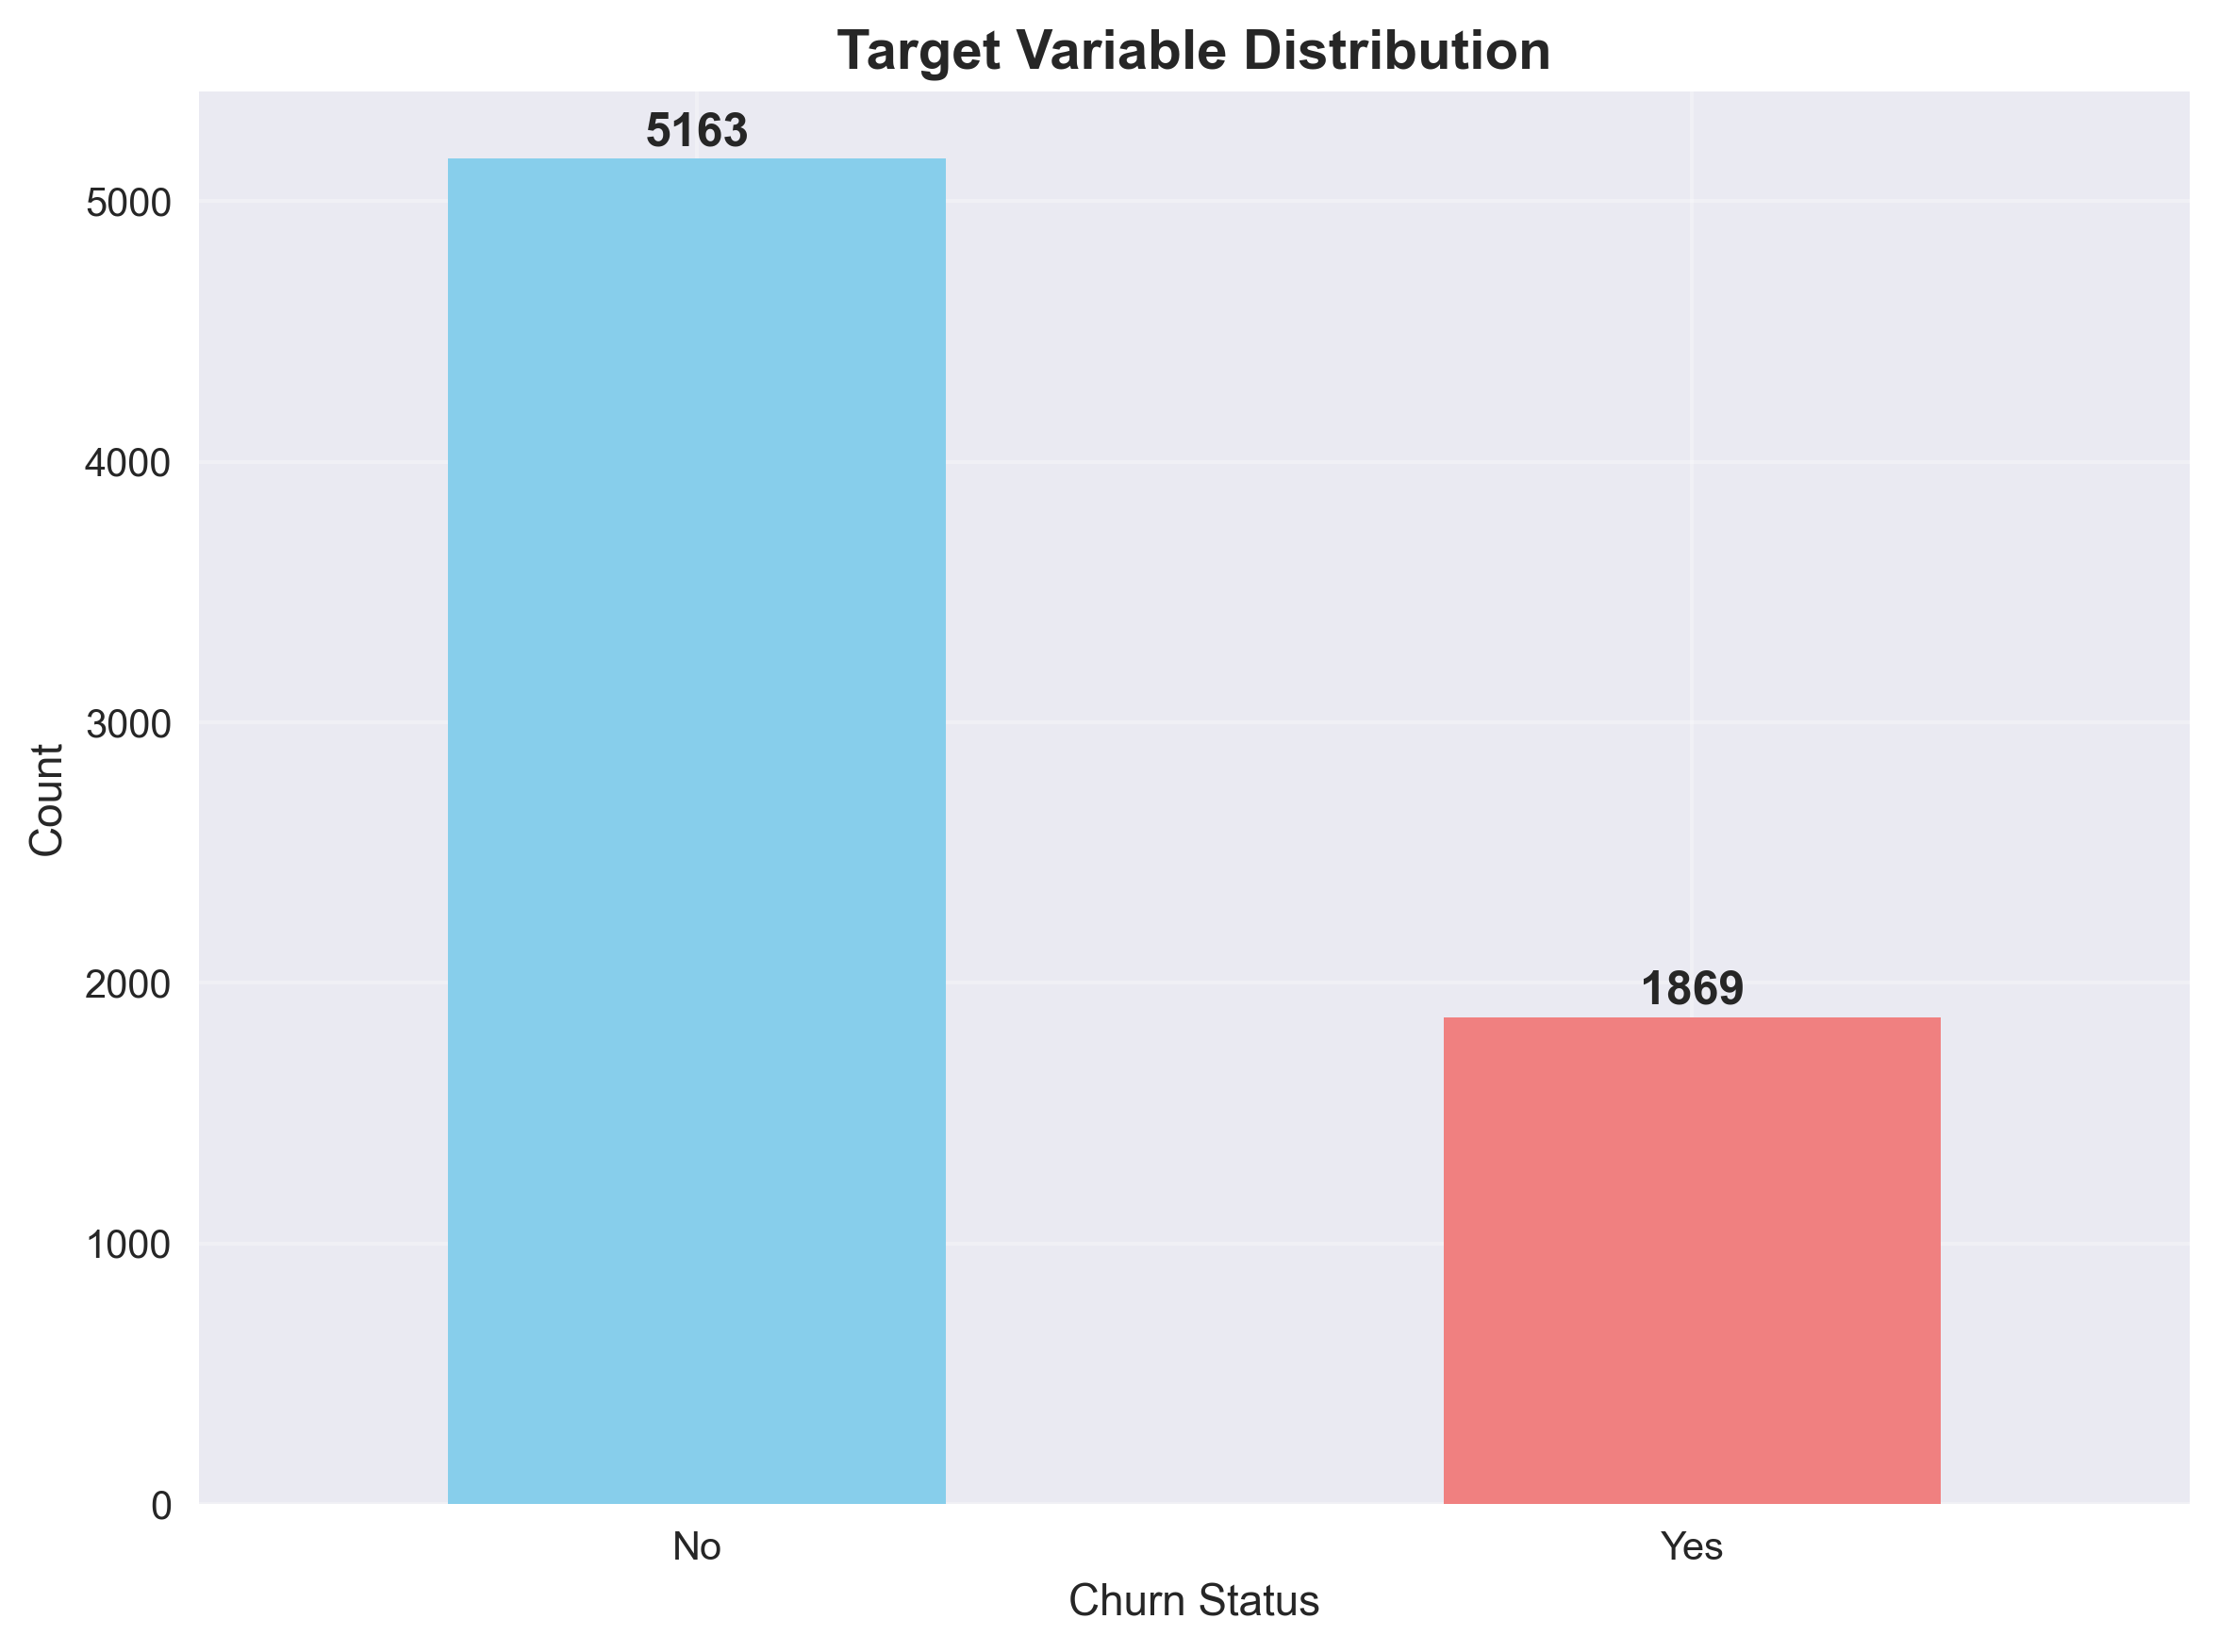


STEP 3: FEATURE ENGINEERING
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 30
Final feature matrix shape: (7032, 30)
Target variable shape: (7032,)


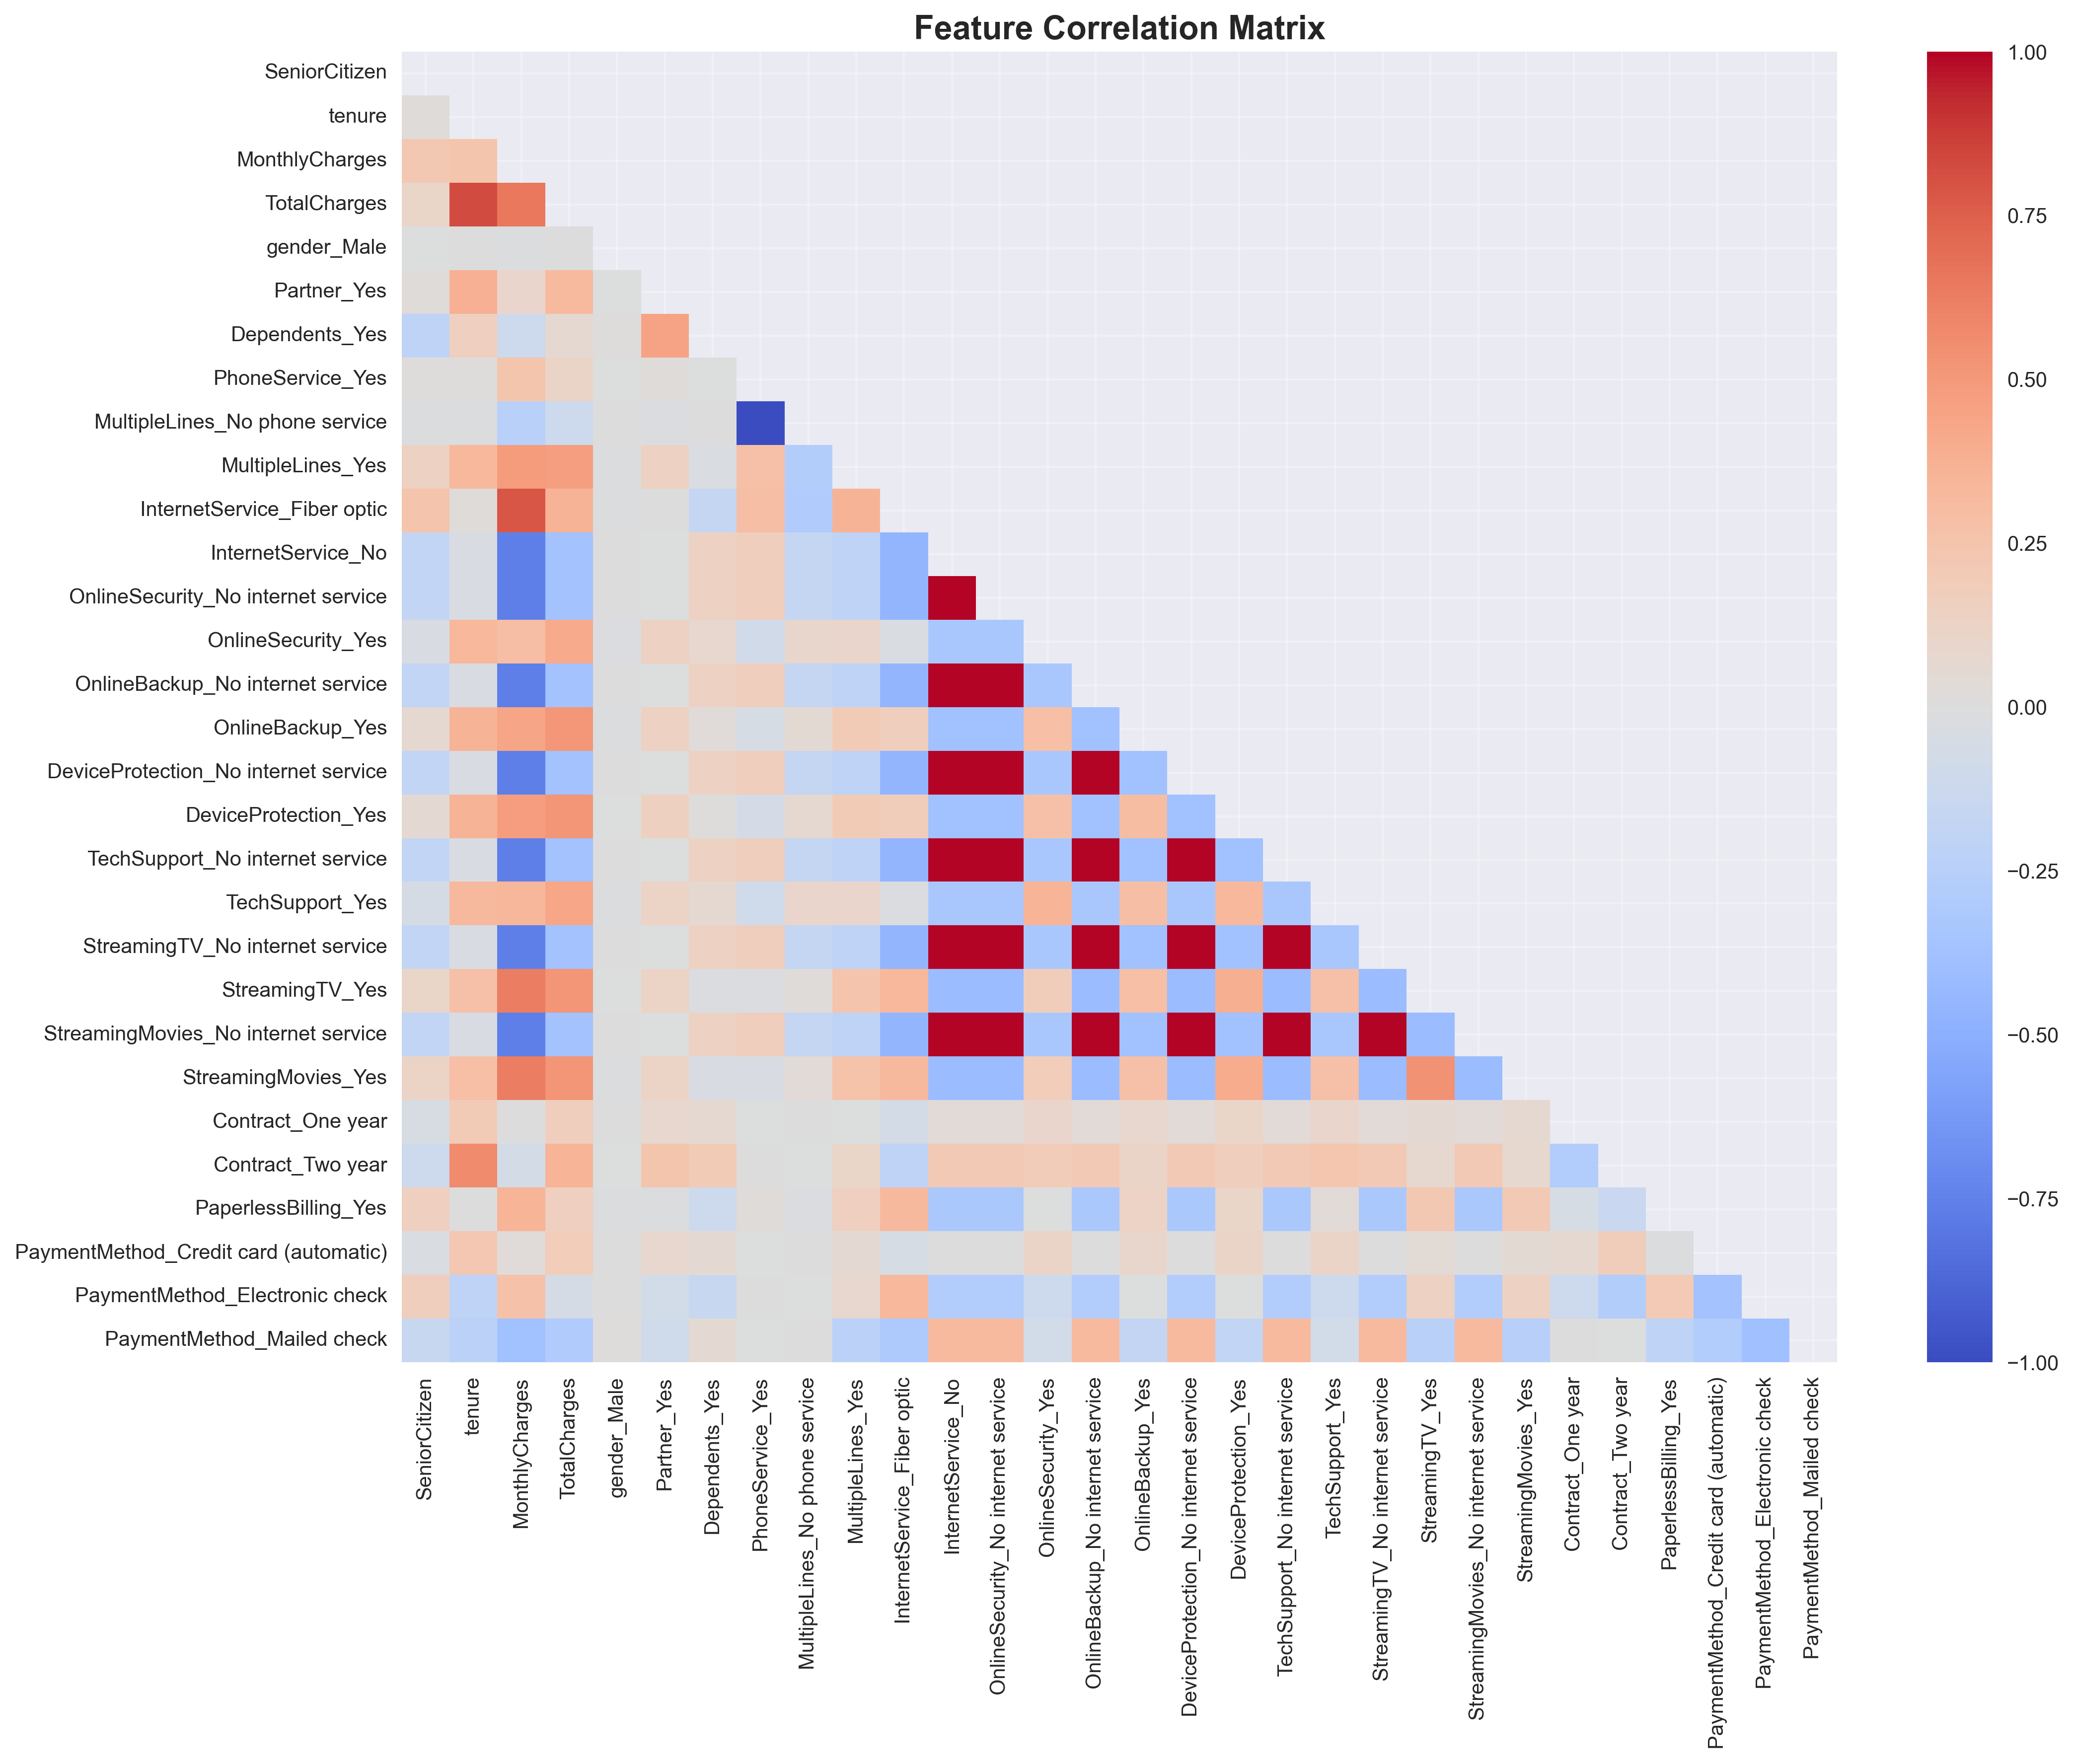


STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
Training set shape: (5625, 30)
Testing set shape: (1407, 30)
Training set class distribution: [4130 1495]
Testing set class distribution: [1033  374]

STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing hyperparameter tuning...
Tuning GBM...
✓ GBM best score: 0.8471
Tuning XGBoost...
✓ XGBoost best score: 0.8490
Tuning RandomForest...
✓ RandomForest best score: 0.8432
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8468
Tuning SVC...
✓ SVC best score: 0.8369
Tuning NeuralNet...
✓ NeuralNet best score: 0.7901
Tuning AdaBoost...
✓ AdaBoost best score: 0.8437

STEP 6: CROSS-VALIDATION EVALUATION
Performing 10-fold cross-validation...
--------------------------------------------------------------------------------
Model           ROC-AUC      Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
GBM             0.847

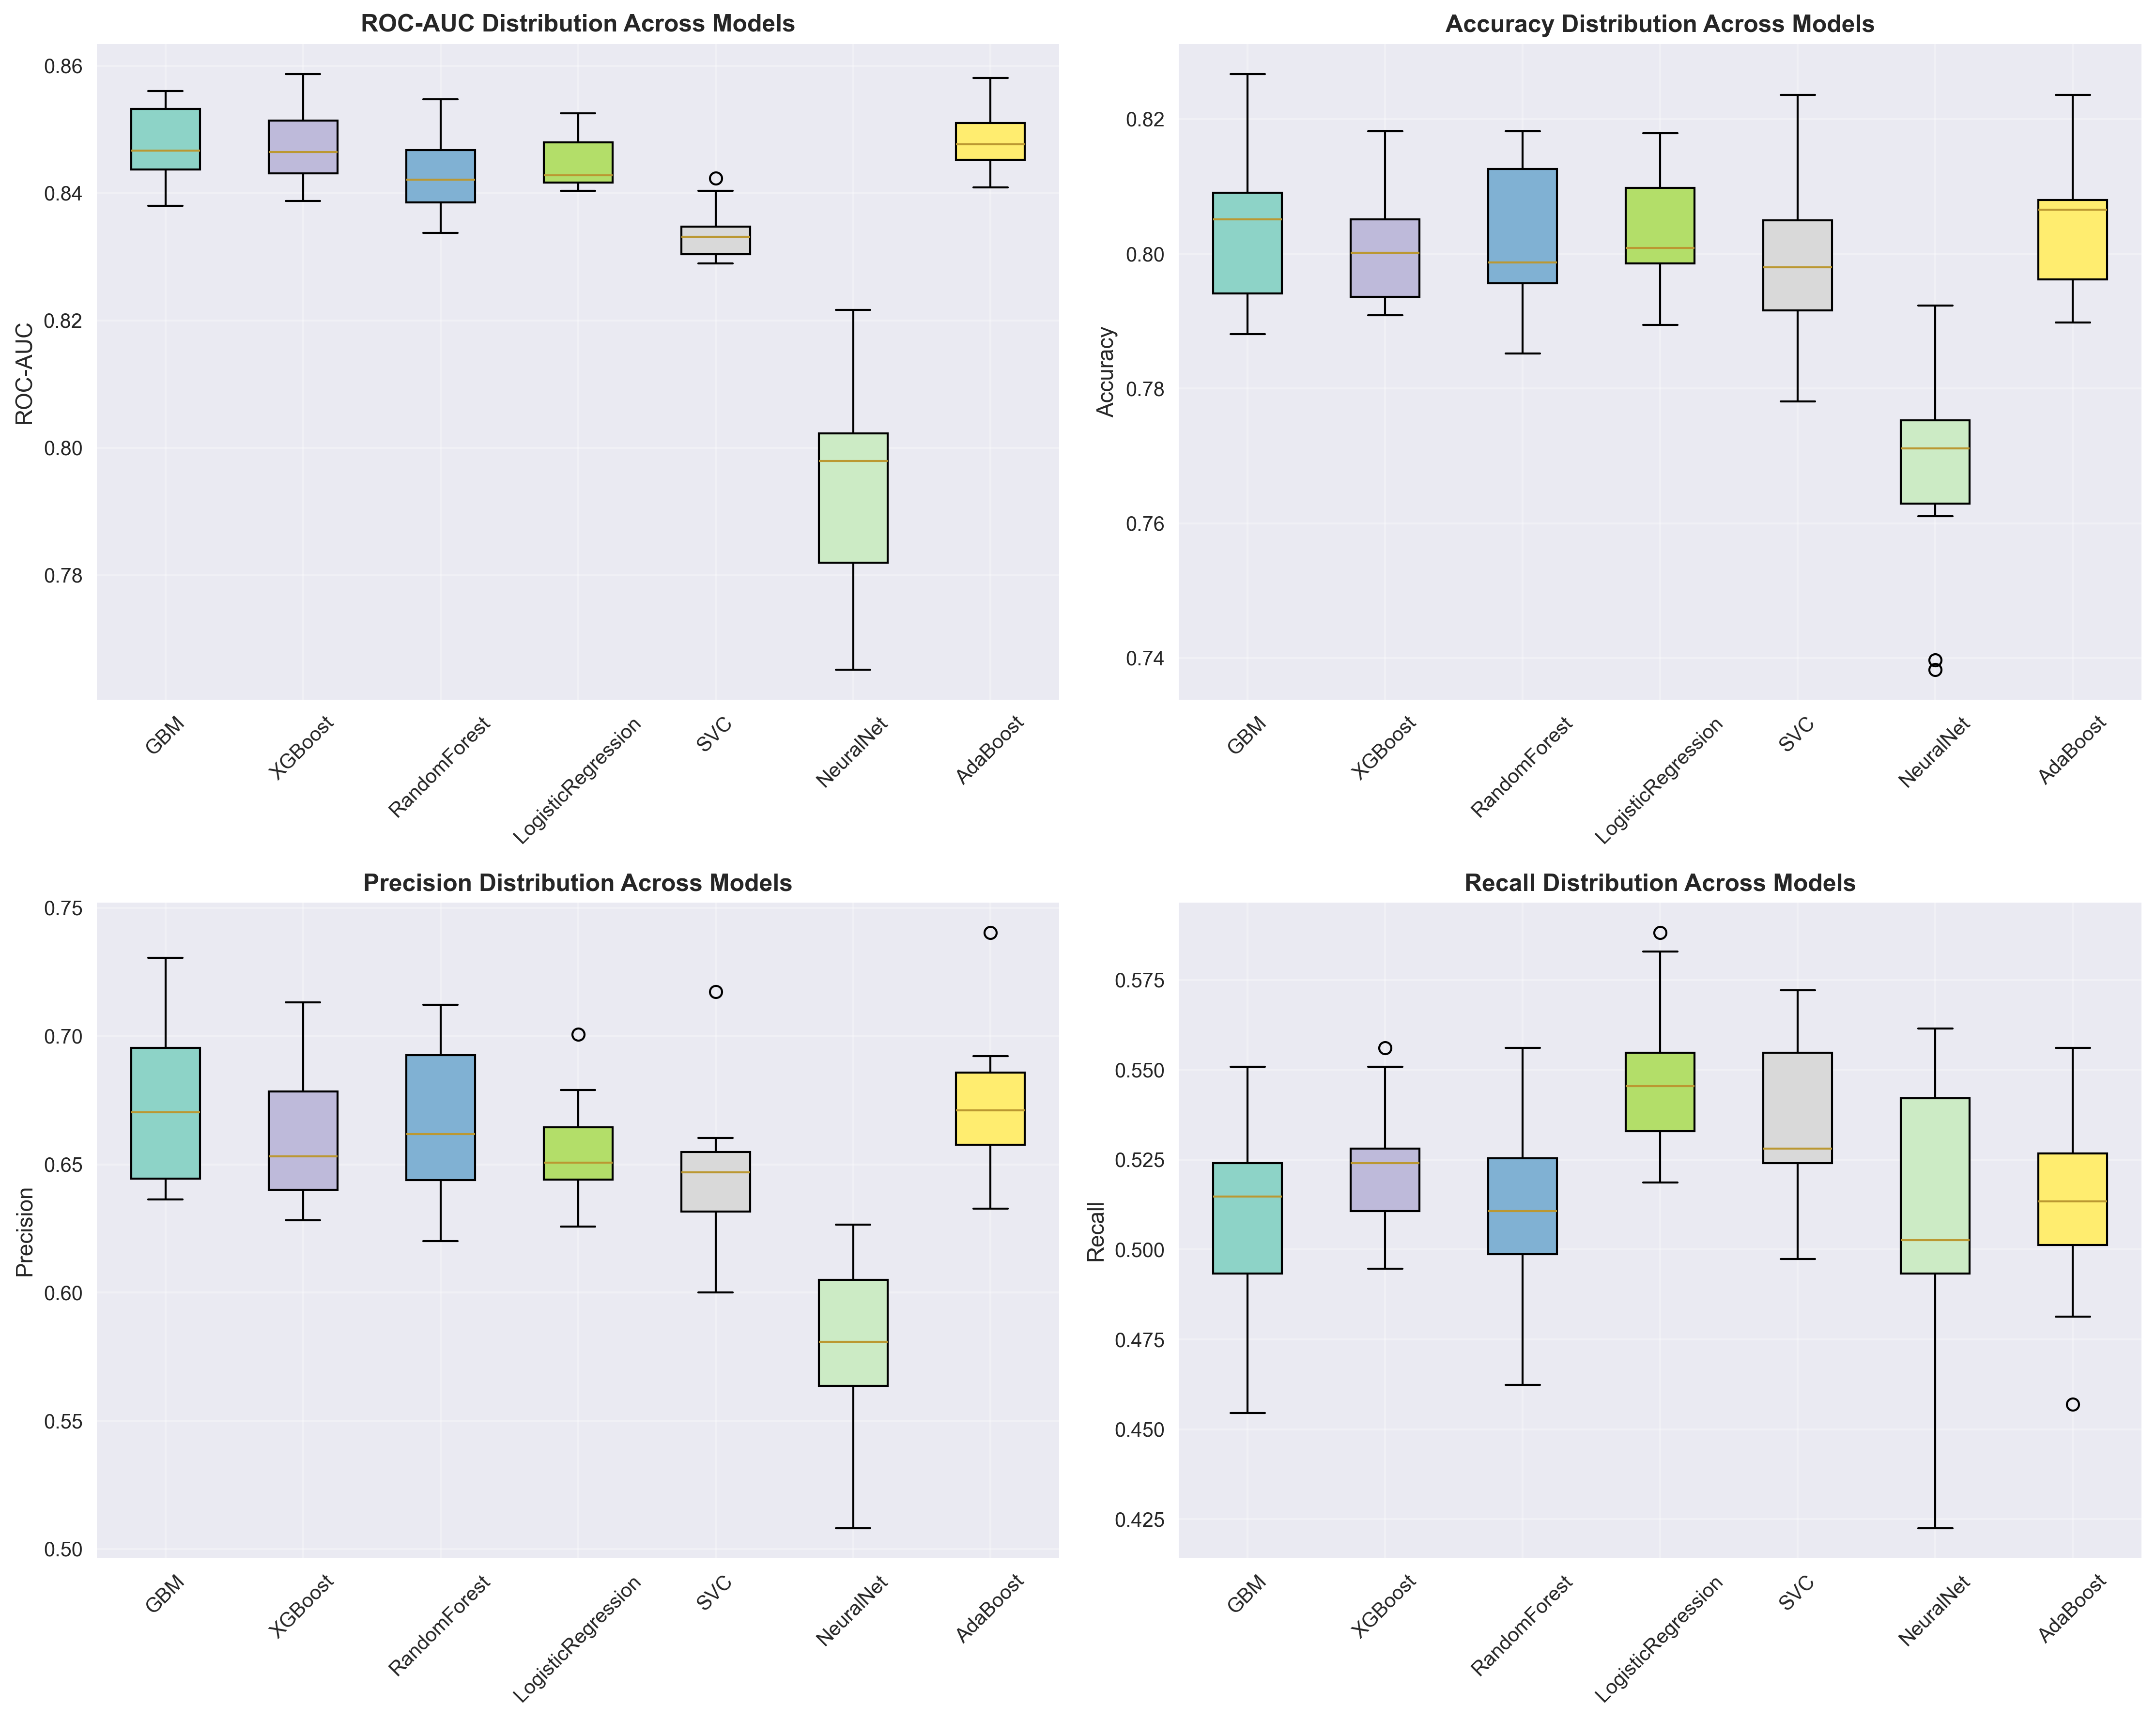


STEP 7: STATISTICAL SIGNIFICANCE TESTING
Wilcoxon Signed-Rank Test Results:
--------------------------------------------------
Best performing model (baseline): AdaBoost
Baseline ROC-AUC: 0.8484 ± 0.0049

GBM             vs AdaBoost: p-value = 0.695312 ns
XGBoost         vs AdaBoost: p-value = 0.921875 ns
RandomForest    vs AdaBoost: p-value = 0.083984 ns
LogisticRegression vs AdaBoost: p-value = 0.160156 ns
SVC             vs AdaBoost: p-value = 0.001953 **
NeuralNet       vs AdaBoost: p-value = 0.001953 **

Friedman Test (Multiple Model Comparison):
Friedman statistic: 40.3714
p-value: 0.000000

STEP 8: FINAL MODEL EVALUATION
Final Model Performance (AdaBoost):
----------------------------------------
ACCURACY  : 0.7939
PRECISION : 0.6438
RECALL    : 0.5027
F1        : 0.5646
ROC_AUC   : 0.8419

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56      

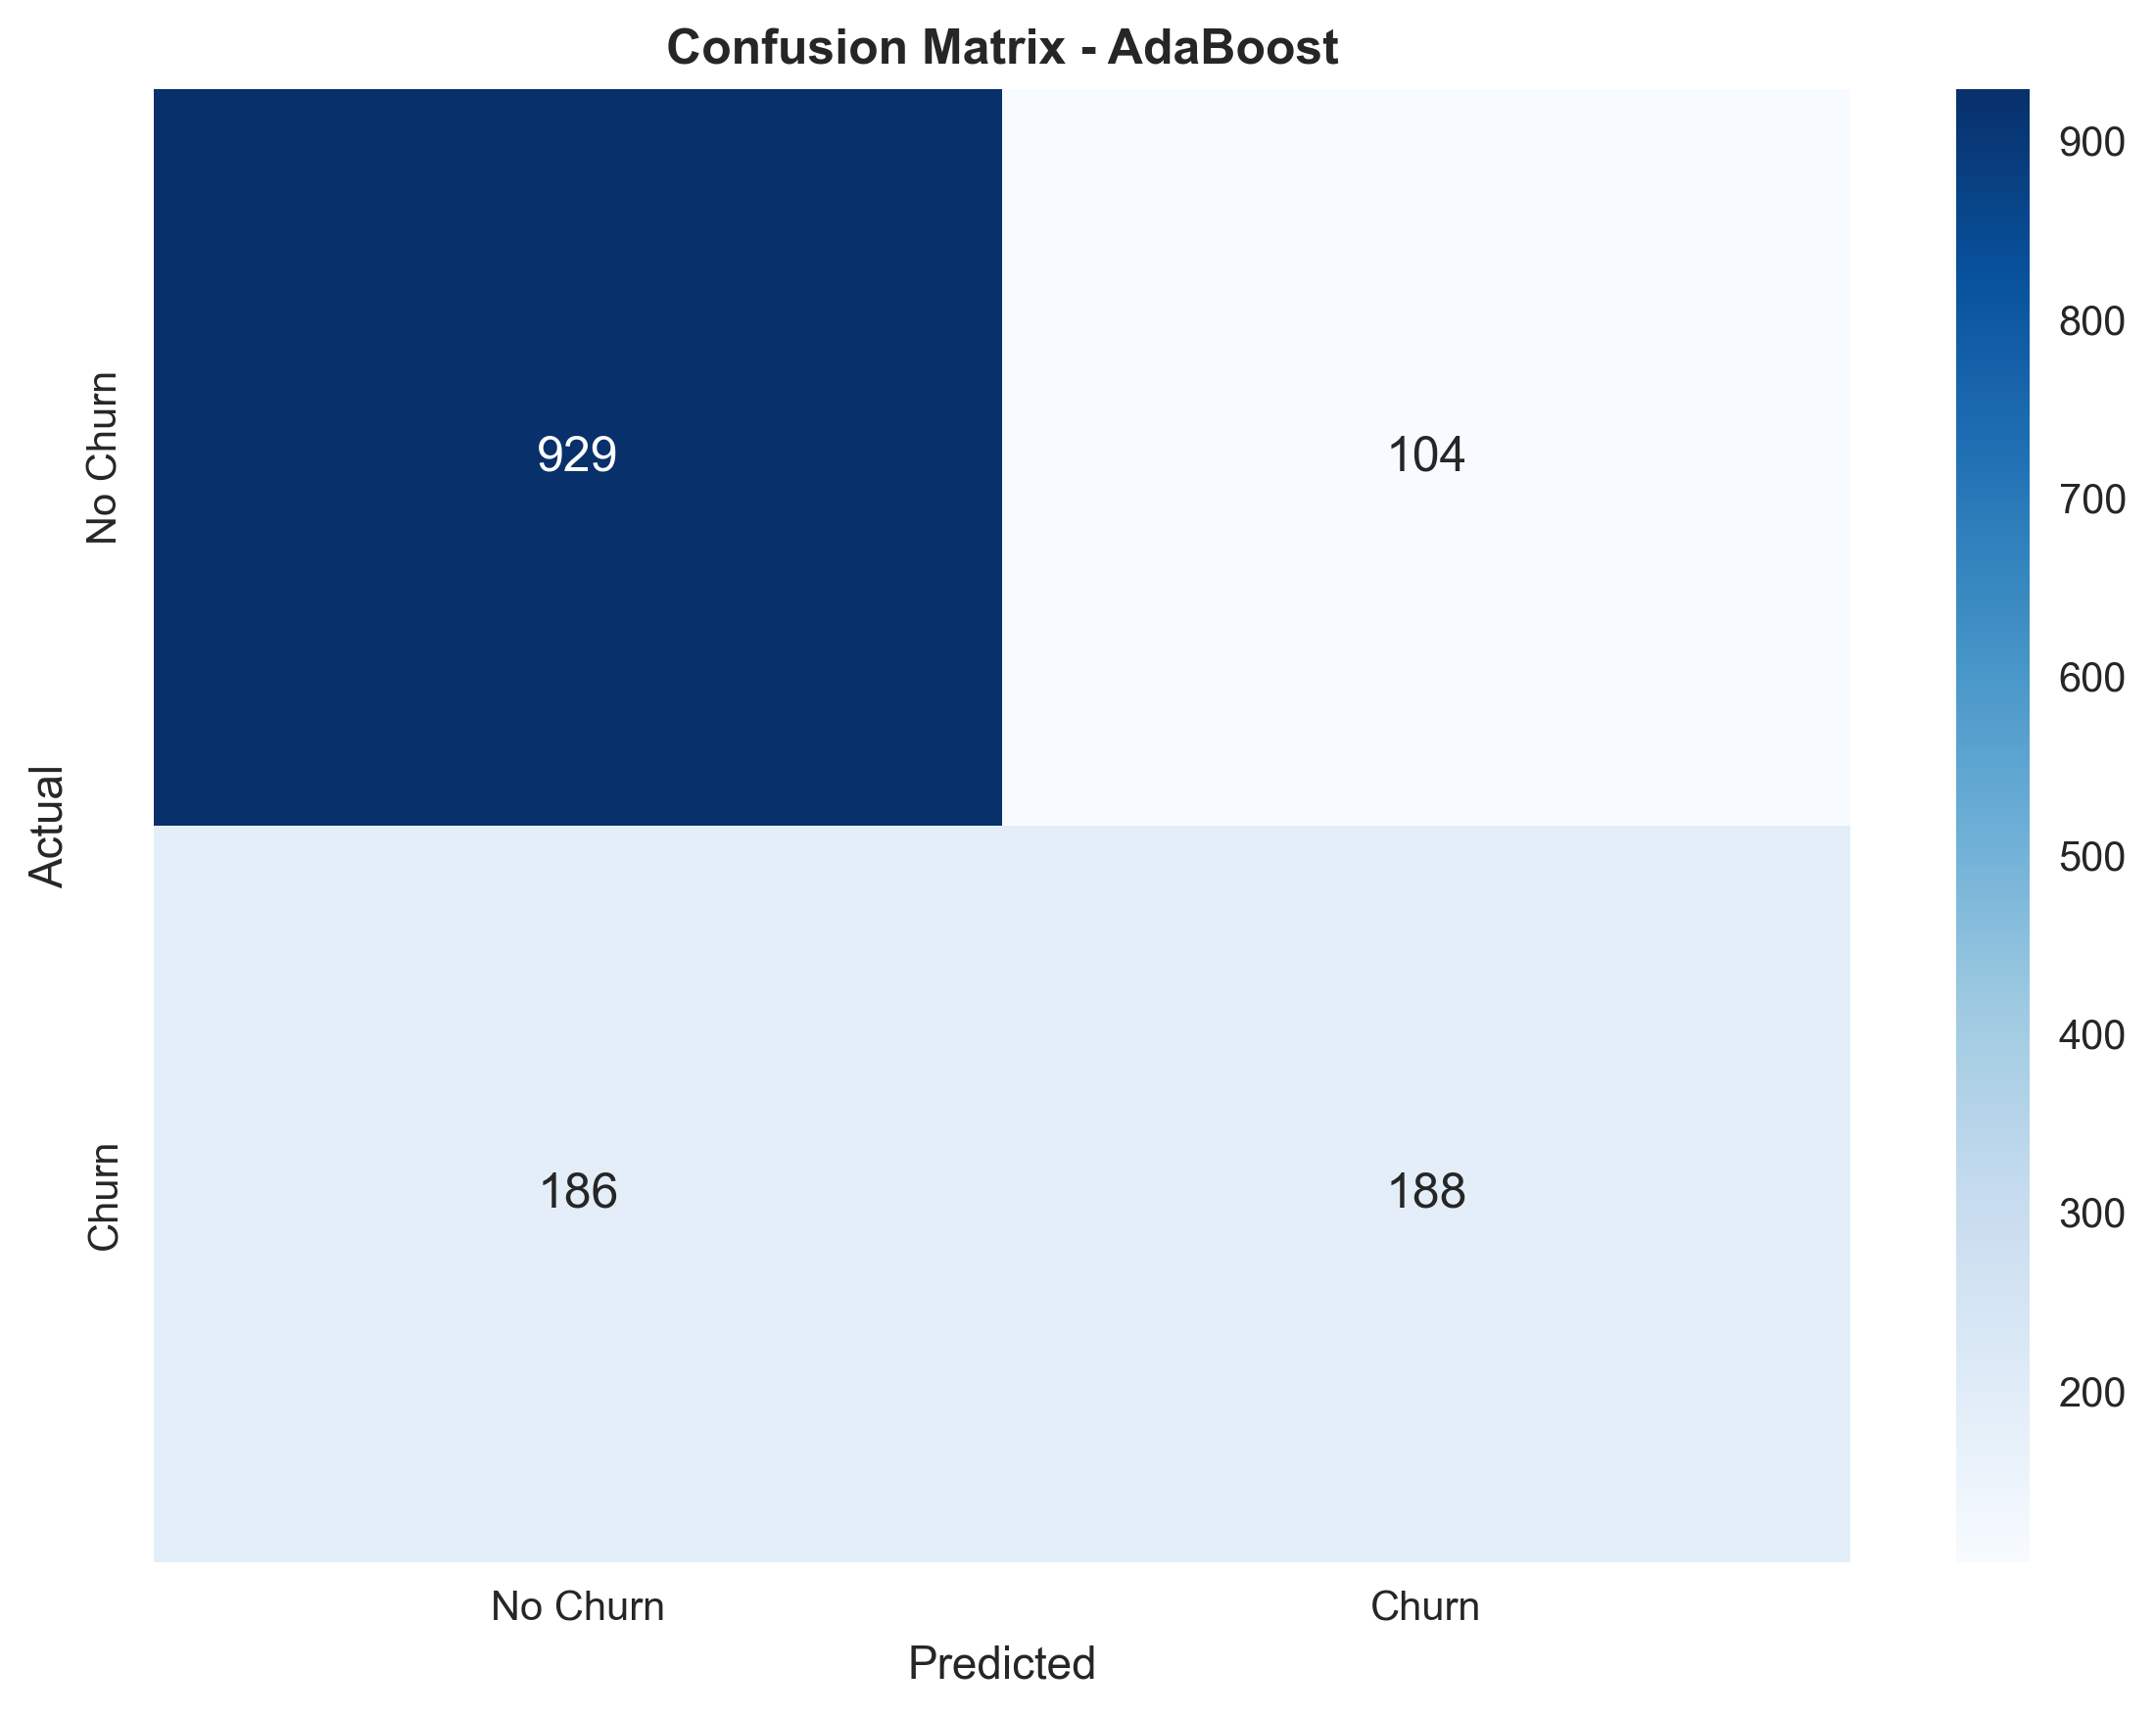

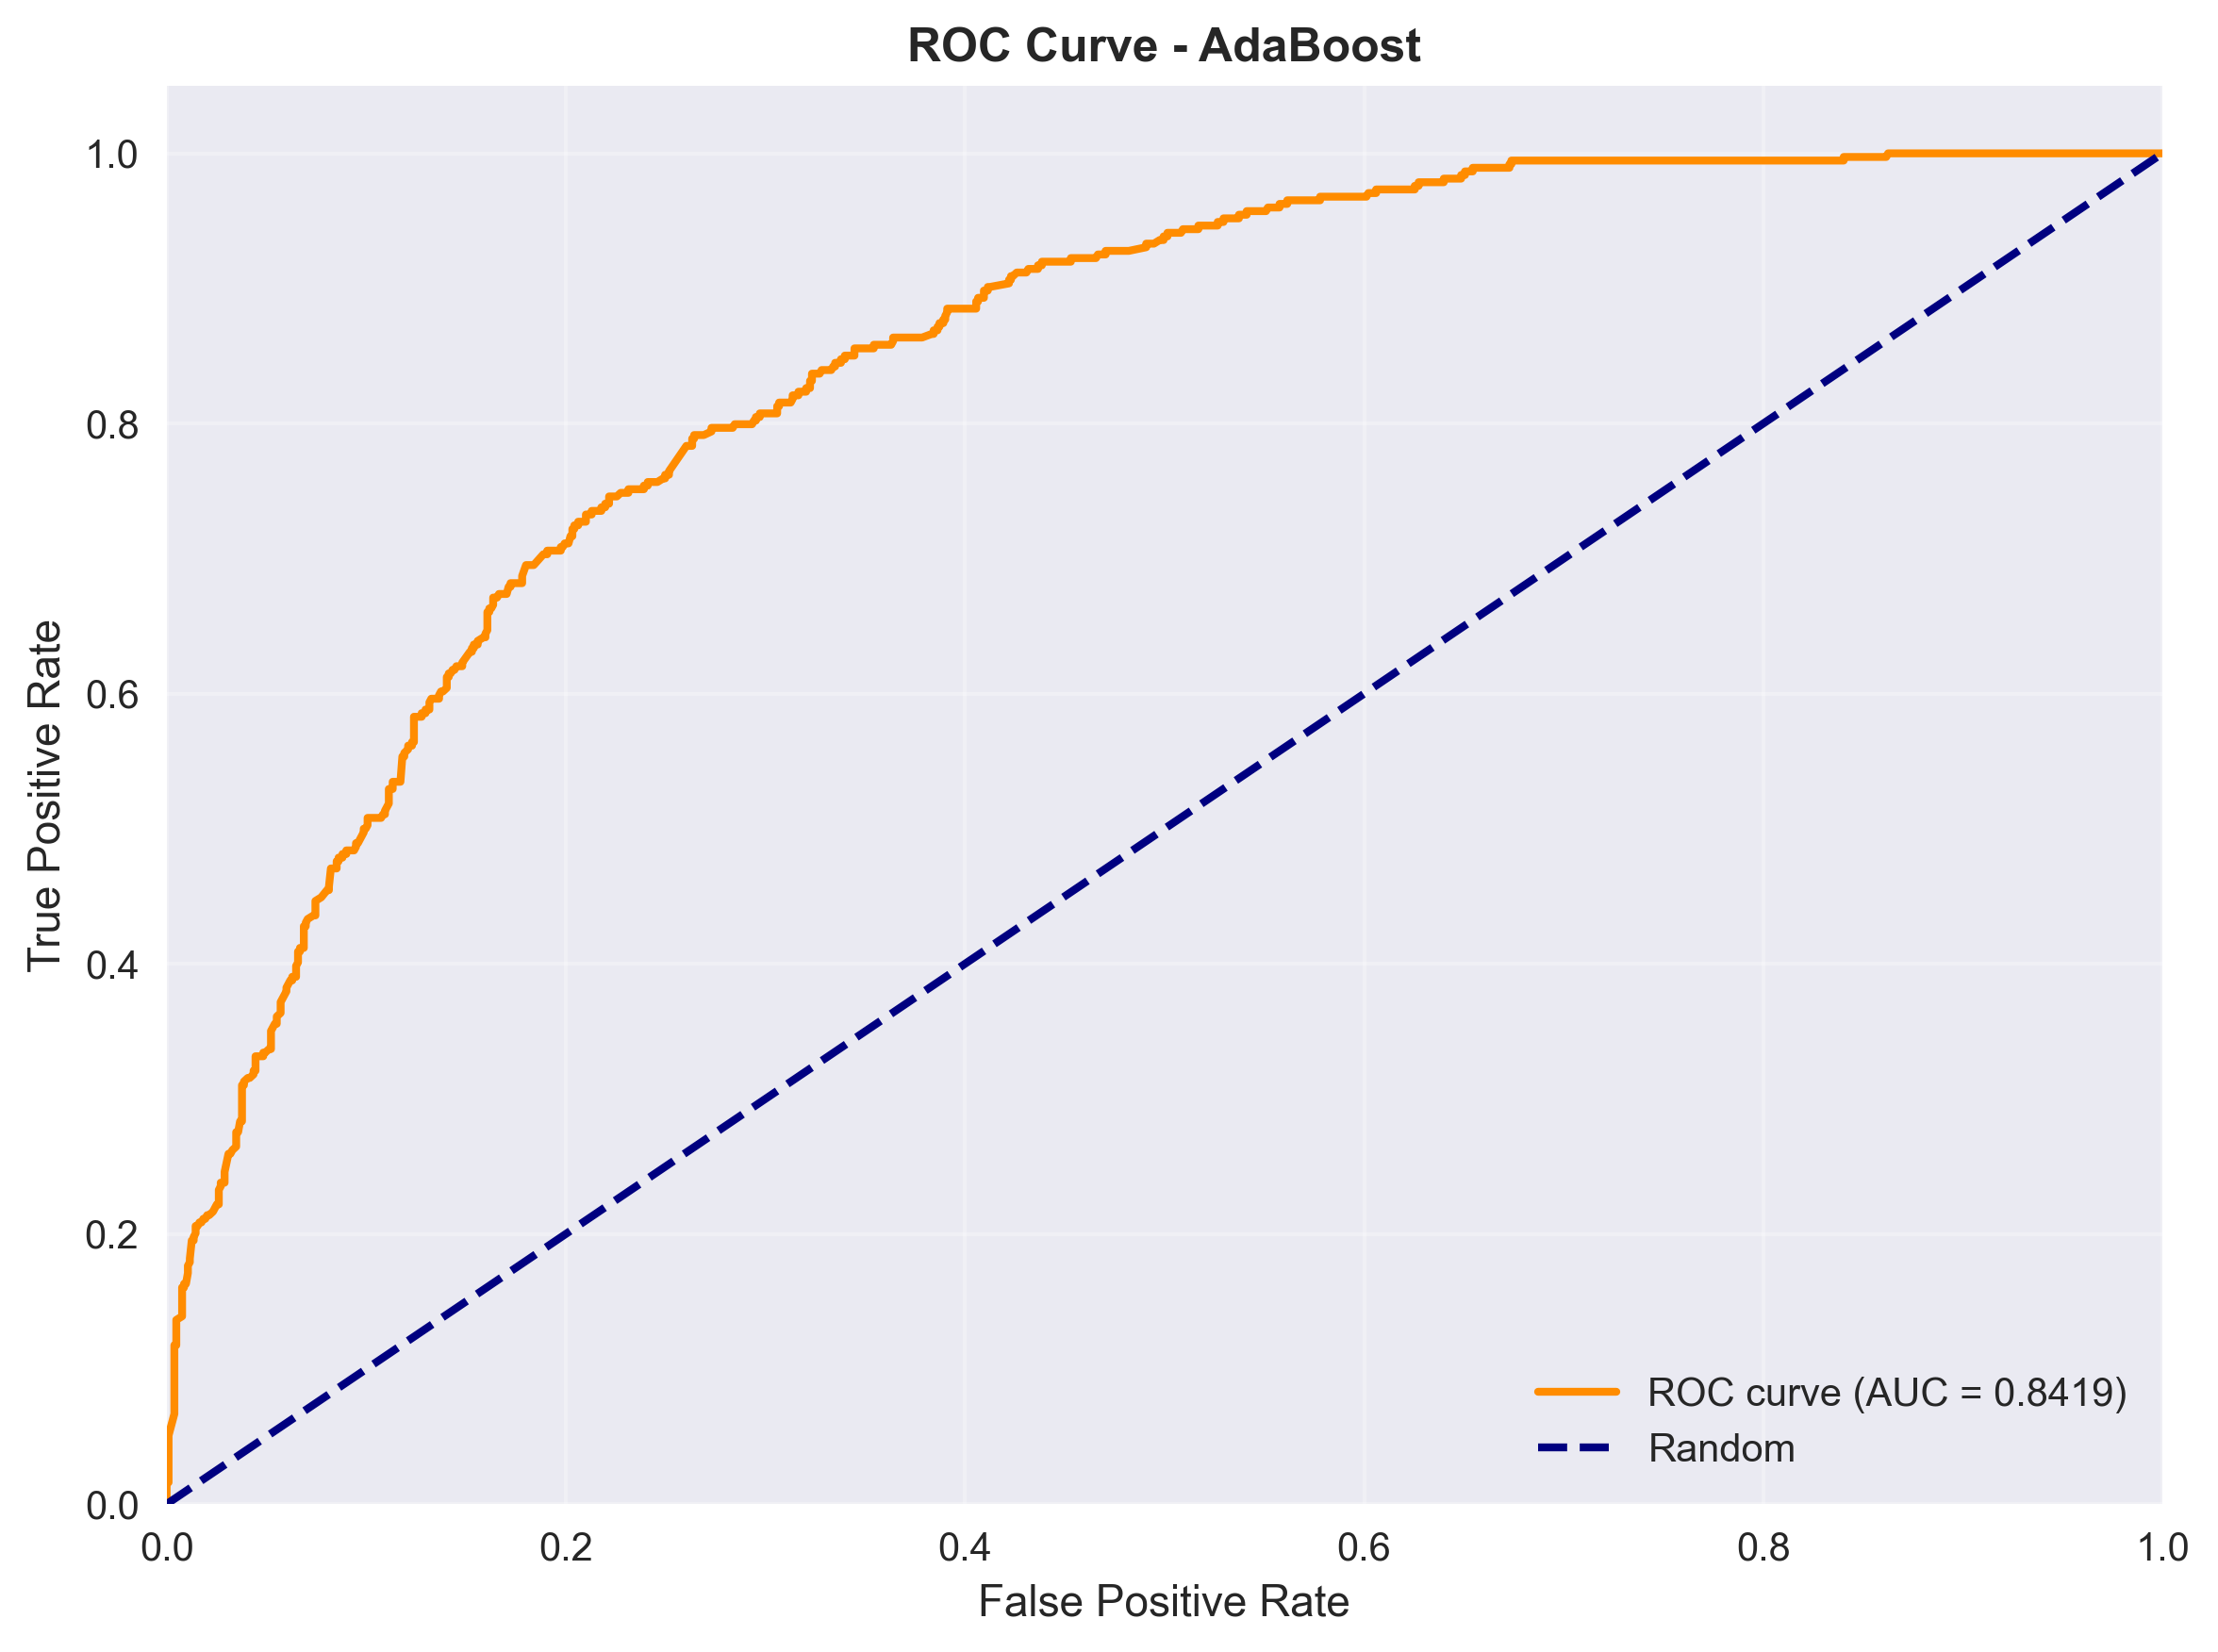

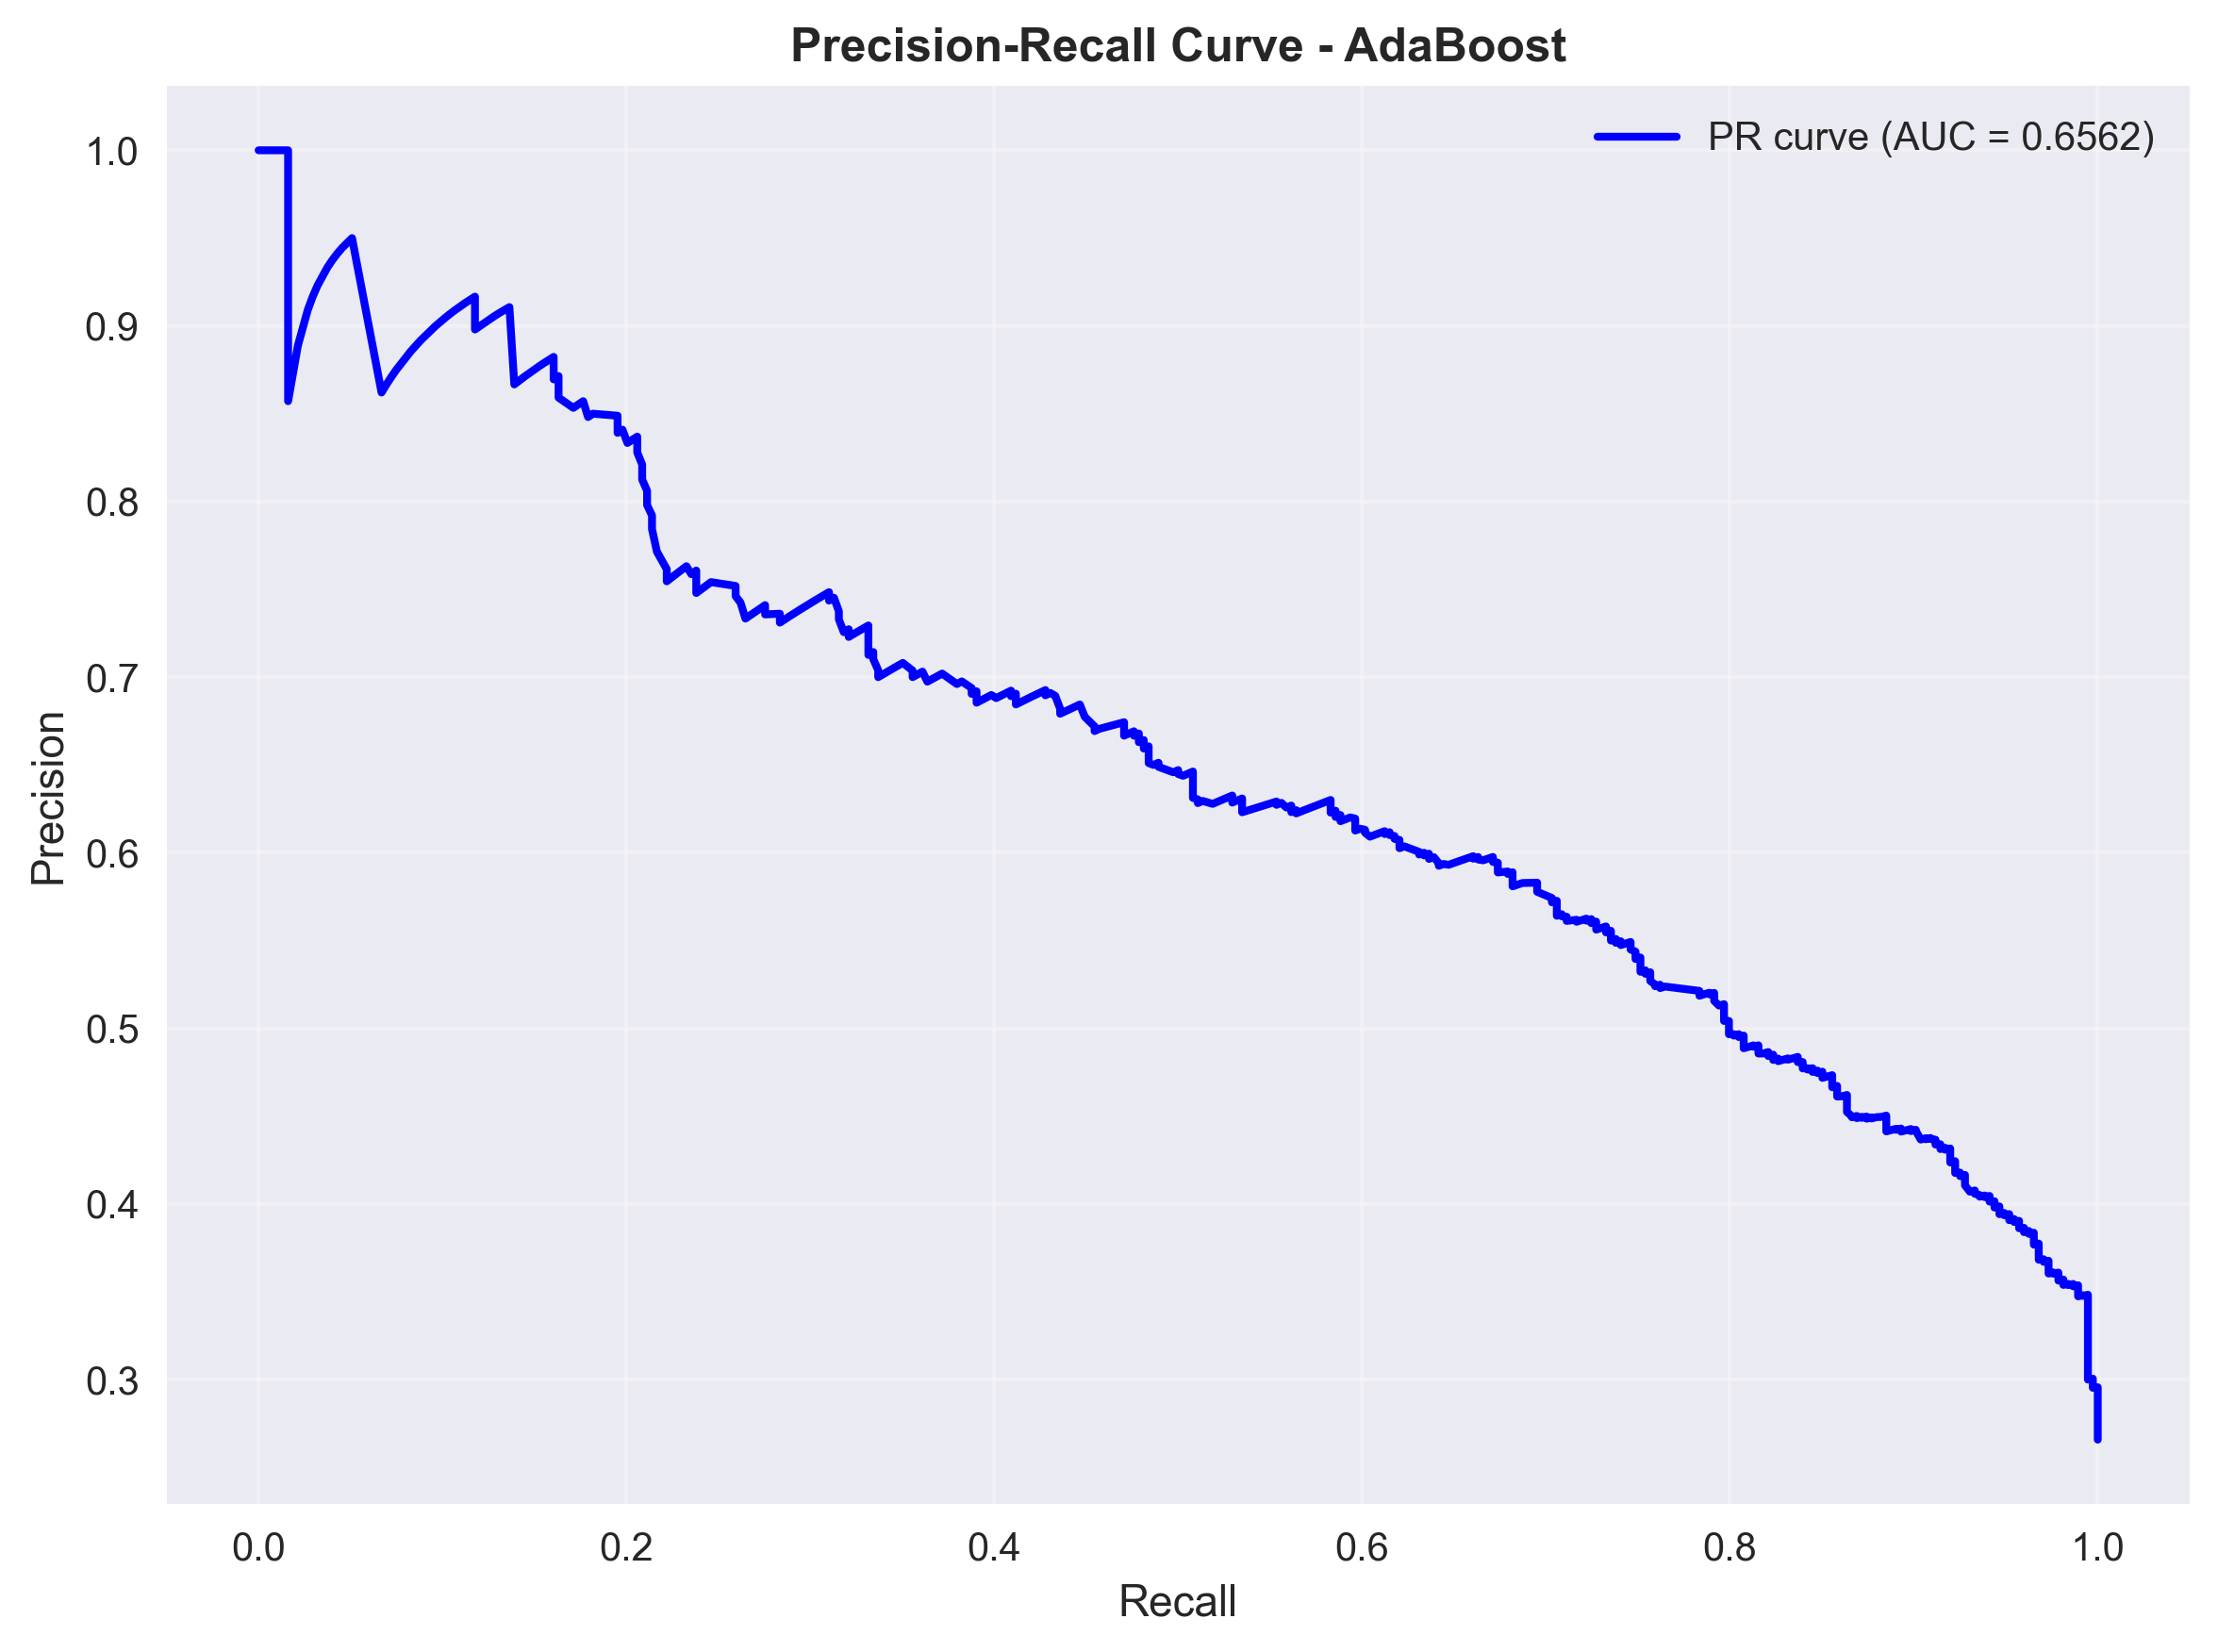

✓ Final model saved as AdaBoost

STEP 9: SHAP EXPLAINABILITY ANALYSIS
Generating SHAP explanations...


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: AdaBoostClassifier(n_estimators=100, random_state=42)

In [6]:
"""
Customer Churn Prediction Analysis using Machine Learning Algorithms
===================================================================
This script performs comprehensive customer churn prediction analysis using multiple ML algorithms
with statistical validation and SHAP explainability for journal publication.

Authors: [Your Name]
Date: June 2024
Journal: [Target Journal Name]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from scipy.stats import wilcoxon, friedmanchisquare
import joblib

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")

    # Basic dataset information
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")

except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    exit()

# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_before = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_before}")

# Remove rows with missing values
df.dropna(inplace=True)
print(f"✓ Removed {missing_before} rows with missing values")
print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print(f"✓ One-hot encoding completed")
print(f"Features after encoding: {df_encoded.shape[1] - 1}")

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)  # Convert to binary

print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis
plt.figure(figsize=(15, 12))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with hyperparameter grids for tuning
models_config = {
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'alpha': [0.001, 0.01]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.5, 1.0, 1.5]
        }
    }
}

# Perform hyperparameter tuning (simplified for demonstration)
print("Performing hyperparameter tuning...")
tuned_models = {}
for name, config in models_config.items():
    print(f"Tuning {name}...")
    # Use a subset of parameters for faster execution
    simple_params = {k: v[:2] if len(v) > 2 else v for k, v in config["params"].items()}

    grid_search = GridSearchCV(
        config["model"],
        simple_params,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"✓ {name} best score: {grid_search.best_score_:.4f}")

# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {}
metrics_results = {}

print("Performing 10-fold cross-validation...")
print("-" * 80)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for name, model in tuned_models.items():
    # ROC-AUC scores
    roc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    prec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='precision')
    rec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')

    cv_results[name] = roc_scores
    metrics_results[name] = {
        'roc_auc': roc_scores,
        'accuracy': acc_scores,
        'precision': prec_scores,
        'recall': rec_scores,
        'f1': f1_scores
    }

    print(f"{name:<15} {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
          f"{acc_scores.mean():.4f}±{acc_scores.std():.3f} "
          f"{prec_scores.mean():.4f}±{prec_scores.std():.3f} "
          f"{rec_scores.mean():.4f}±{rec_scores.std():.3f} "
          f"{f1_scores.mean():.4f}±{f1_scores.std():.3f}")

# Create performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
titles = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx//2, idx%2]
    data = [metrics_results[model][metric] for model in tuned_models.keys()]
    labels = list(tuned_models.keys())

    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    ax.set_title(f'{title} Distribution Across Models', fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)

    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Wilcoxon signed-rank test (pairwise comparison)
print("Wilcoxon Signed-Rank Test Results:")
print("-" * 50)
best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
print(f"Best performing model (baseline): {best_model}")
print(f"Baseline ROC-AUC: {cv_results[best_model].mean():.4f} ± {cv_results[best_model].std():.4f}")
print()

baseline_scores = cv_results[best_model]
significance_results = {}

for name, scores in cv_results.items():
    if name != best_model:
        stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
        significance_results[name] = p_value
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{name:<15} vs {best_model}: p-value = {p_value:.6f} {significance}")

# Friedman test for multiple model comparison
print(f"\nFriedman Test (Multiple Model Comparison):")
all_scores = [scores for scores in cv_results.values()]
friedman_stat, friedman_p = friedmanchisquare(*all_scores)
print(f"Friedman statistic: {friedman_stat:.4f}")
print(f"p-value: {friedman_p:.6f}")

# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION")
print("="*50)

# Train the best model on full training set
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")
print(f"✓ Final model saved as {best_model}")

# === STEP 9: SHAP EXPLAINABILITY ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: SHAP EXPLAINABILITY ANALYSIS")
print("="*50)

print("Generating SHAP explanations...")
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test[:1000])  # Use subset for faster computation

# Feature importance plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=pd.DataFrame(X_test[:1000], columns=X.columns),
                  plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=pd.DataFrame(X_test[:1000], columns=X.columns), show=False)
plt.title('SHAP Summary Plot', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# SHAP waterfall plot for first instance
plt.figure(figsize=(10, 8))
shap.plots.waterfall(shap_values[0], show=False)
plt.title('SHAP Waterfall Plot (Sample Instance)', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/shap_waterfall.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 10: SAVE RESULTS AND DATA ===
print("\n" + "="*50)
print("STEP 10: SAVING RESULTS AND DATA")
print("="*50)

# Save cross-validation results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(f"{OUTPUT_DIR}/data/cv_results.csv", index=False)
print("✓ Cross-validation results saved")

# Save comprehensive metrics
metrics_df = pd.DataFrame({
    'Model': list(tuned_models.keys()),
    'ROC_AUC_mean': [metrics_results[m]['roc_auc'].mean() for m in tuned_models.keys()],
    'ROC_AUC_std': [metrics_results[m]['roc_auc'].std() for m in tuned_models.keys()],
    'Accuracy_mean': [metrics_results[m]['accuracy'].mean() for m in tuned_models.keys()],
    'Accuracy_std': [metrics_results[m]['accuracy'].std() for m in tuned_models.keys()],
    'Precision_mean': [metrics_results[m]['precision'].mean() for m in tuned_models.keys()],
    'Precision_std': [metrics_results[m]['precision'].std() for m in tuned_models.keys()],
    'Recall_mean': [metrics_results[m]['recall'].mean() for m in tuned_models.keys()],
    'Recall_std': [metrics_results[m]['recall'].std() for m in tuned_models.keys()],
    'F1_mean': [metrics_results[m]['f1'].mean() for m in tuned_models.keys()],
    'F1_std': [metrics_results[m]['f1'].std() for m in tuned_models.keys()]
})
metrics_df.to_csv(f"{OUTPUT_DIR}/data/model_performance_metrics.csv", index=False)
print("✓ Model performance metrics saved")

# Save statistical test results
stats_df = pd.DataFrame({
    'Model': list(significance_results.keys()),
    'Wilcoxon_p_value': list(significance_results.values()),
    'Significant_at_0.05': [p < 0.05 for p in significance_results.values()]
})
stats_df.to_csv(f"{OUTPUT_DIR}/data/statistical_tests.csv", index=False)
print("✓ Statistical test results saved")

# Save final test metrics
final_metrics_df = pd.DataFrame([test_metrics])
final_metrics_df.to_csv(f"{OUTPUT_DIR}/data/final_model_metrics.csv", index=False)
print("✓ Final model metrics saved")

# Save feature names
feature_names_df = pd.DataFrame({'Feature': X.columns})
feature_names_df.to_csv(f"{OUTPUT_DIR}/data/feature_names.csv", index=False)
print("✓ Feature names saved")

# Save processed dataset
df_processed = pd.DataFrame(X_scaled, columns=X.columns)
df_processed['target'] = y
df_processed.to_csv(f"{OUTPUT_DIR}/data/processed_dataset.csv", index=False)
print("✓ Processed dataset saved")

# === ANALYSIS SUMMARY ===
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"✓ Dataset: {df.shape} → {X.shape} (after preprocessing)")
print(f"✓ Best Model: {best_model} (ROC-AUC: {cv_results[best_model].mean():.4f})")
print(f"✓ Test Performance: {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"✓ Statistical Tests: Wilcoxon & Friedman completed")
print(f"✓ SHAP Analysis: Feature importance and explanations generated")
print(f"✓ All outputs saved to: {OUTPUT_DIR}/")
print(f"  - Plots: {len(os.listdir(f'{OUTPUT_DIR}/plots'))} files")
print(f"  - Data: {len(os.listdir(f'{OUTPUT_DIR}/data'))} files")
print(f"  - Models: {len(os.listdir(f'{OUTPUT_DIR}/models'))} files")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Display final metrics table for journal
print("\nFINAL RESULTS TABLE (For Journal Publication):")
print("="*80)
print(metrics_df.round(4).to_string(index=False))
print("="*80)

CUSTOMER CHURN PREDICTION ANALYSIS
Analysis started at: 2025-06-16 14:21:54
Output directory: rill_final

STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0

STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 11
✓ Removed 11 rows with missing values
Final dataset shape: (7032, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5163 (73.42%)
- Yes: 1869 (26.58%)


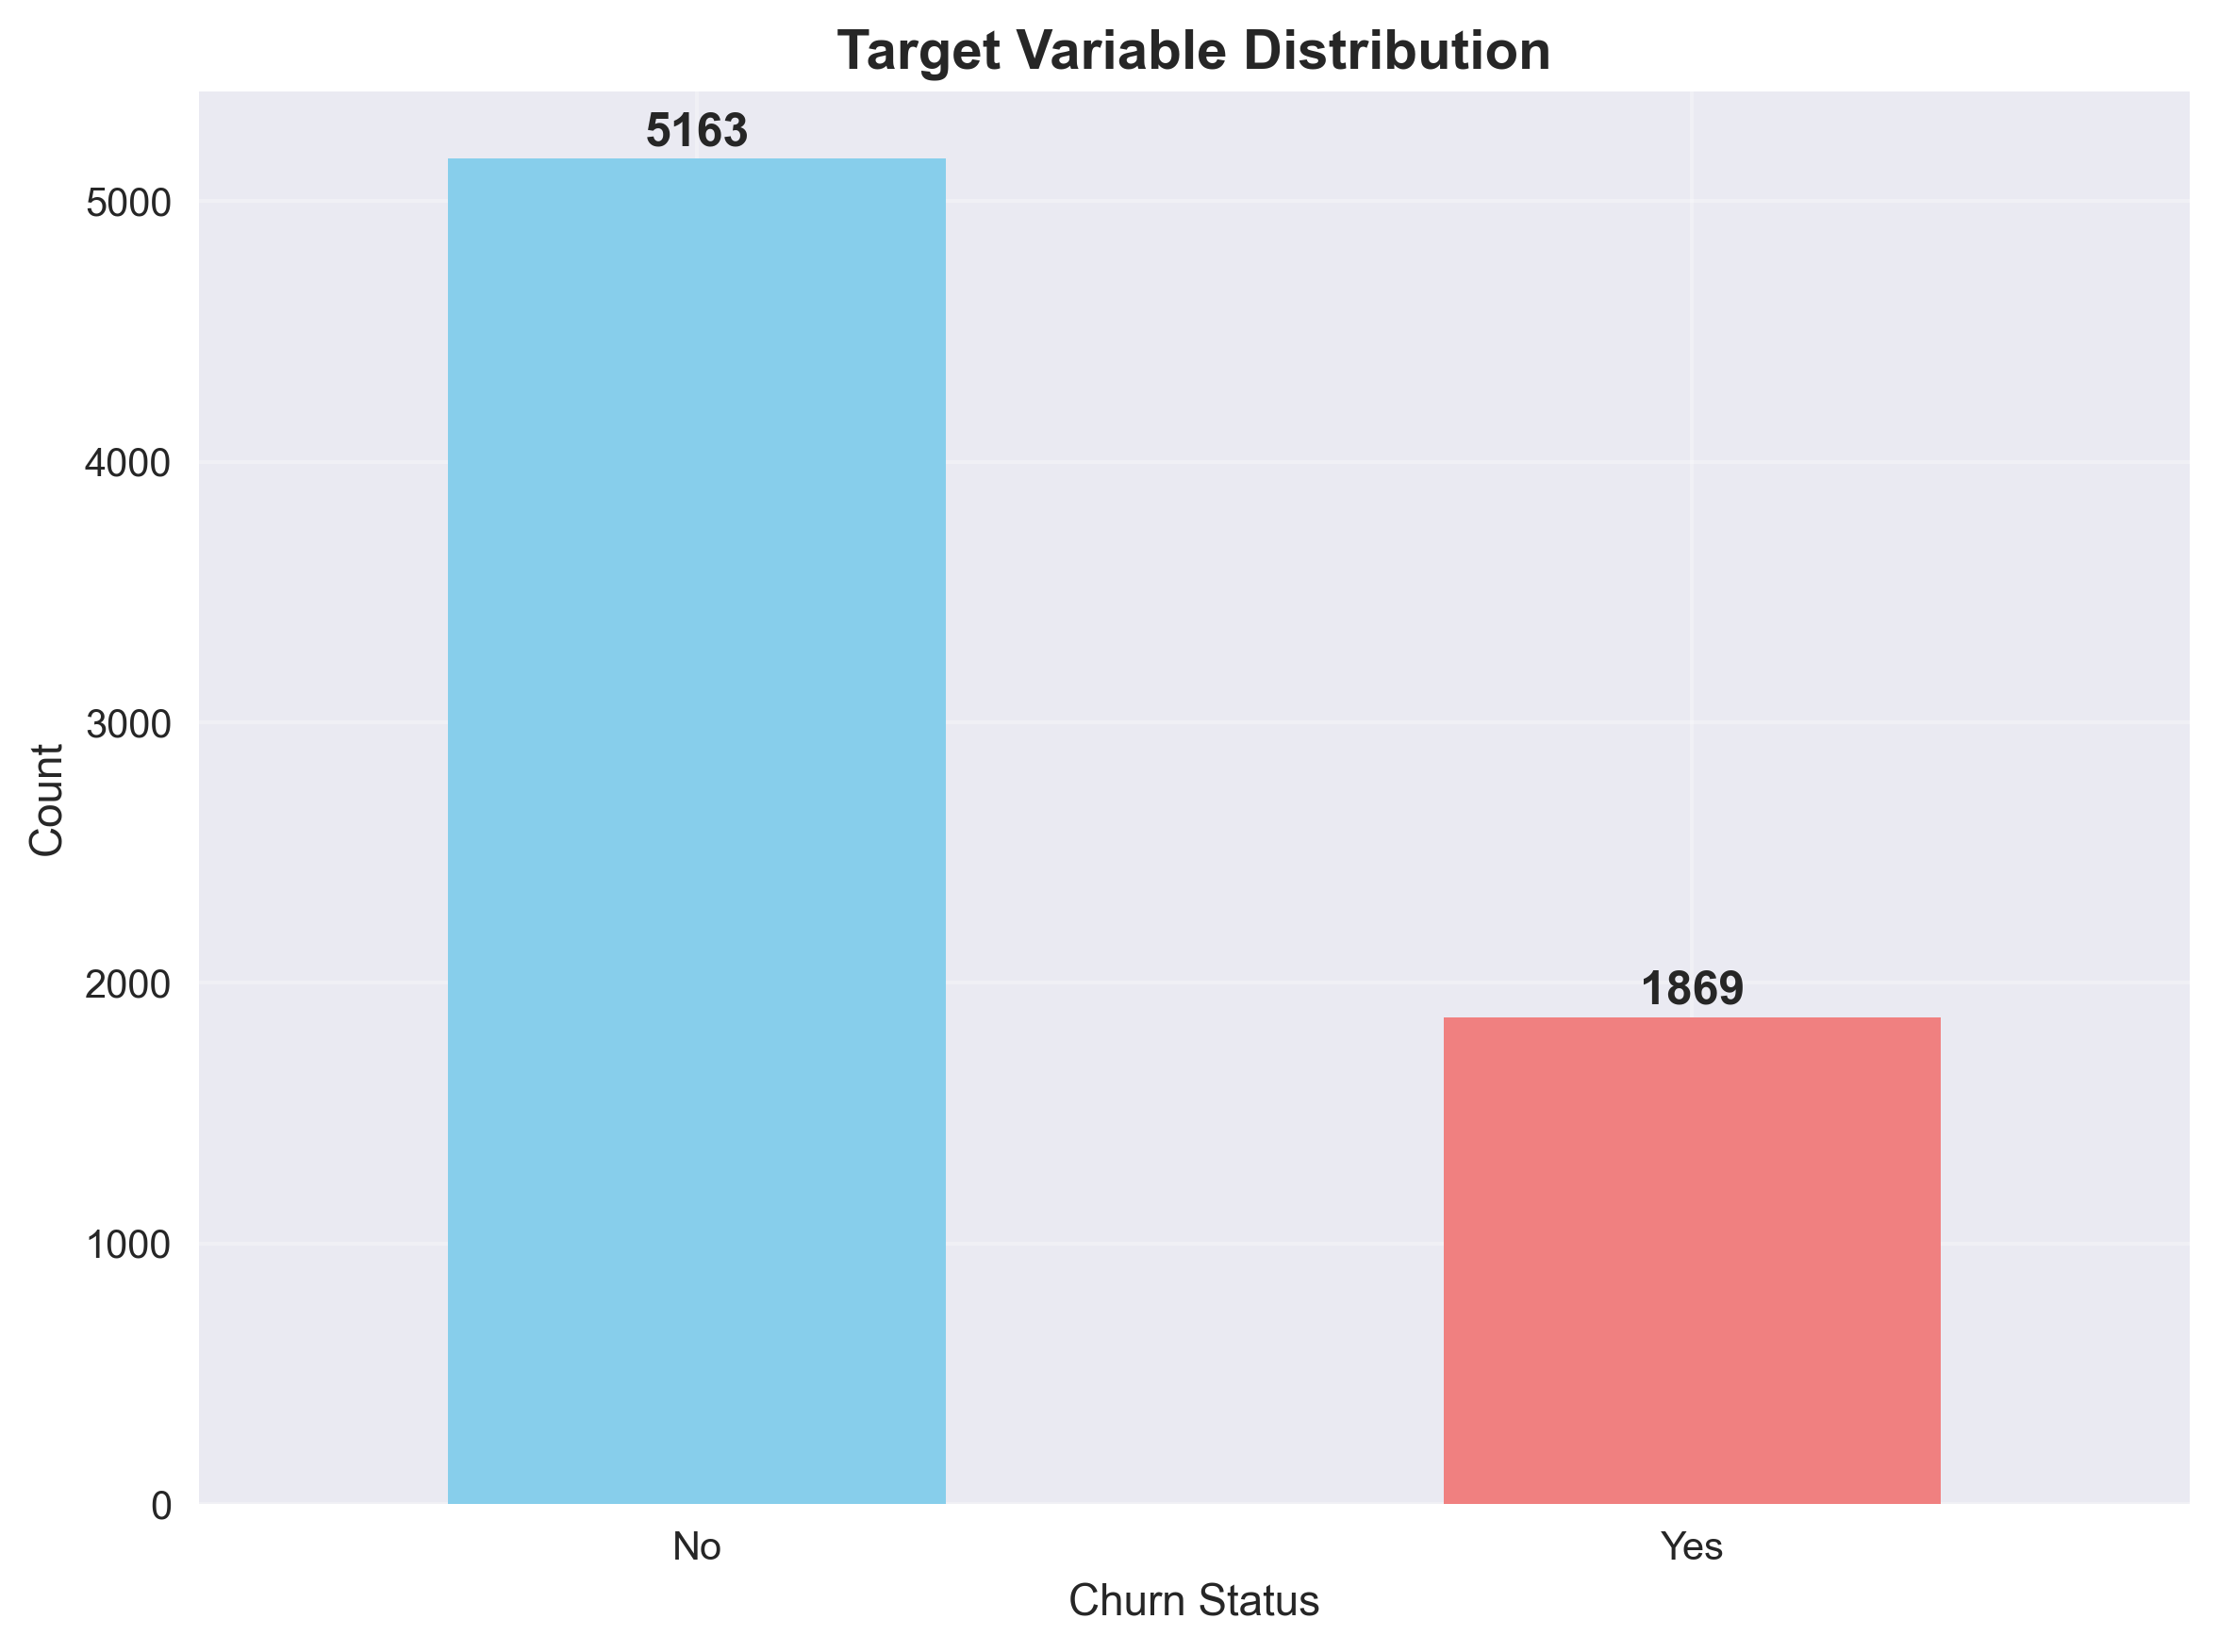


STEP 3: FEATURE ENGINEERING
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 30
Final feature matrix shape: (7032, 30)
Target variable shape: (7032,)


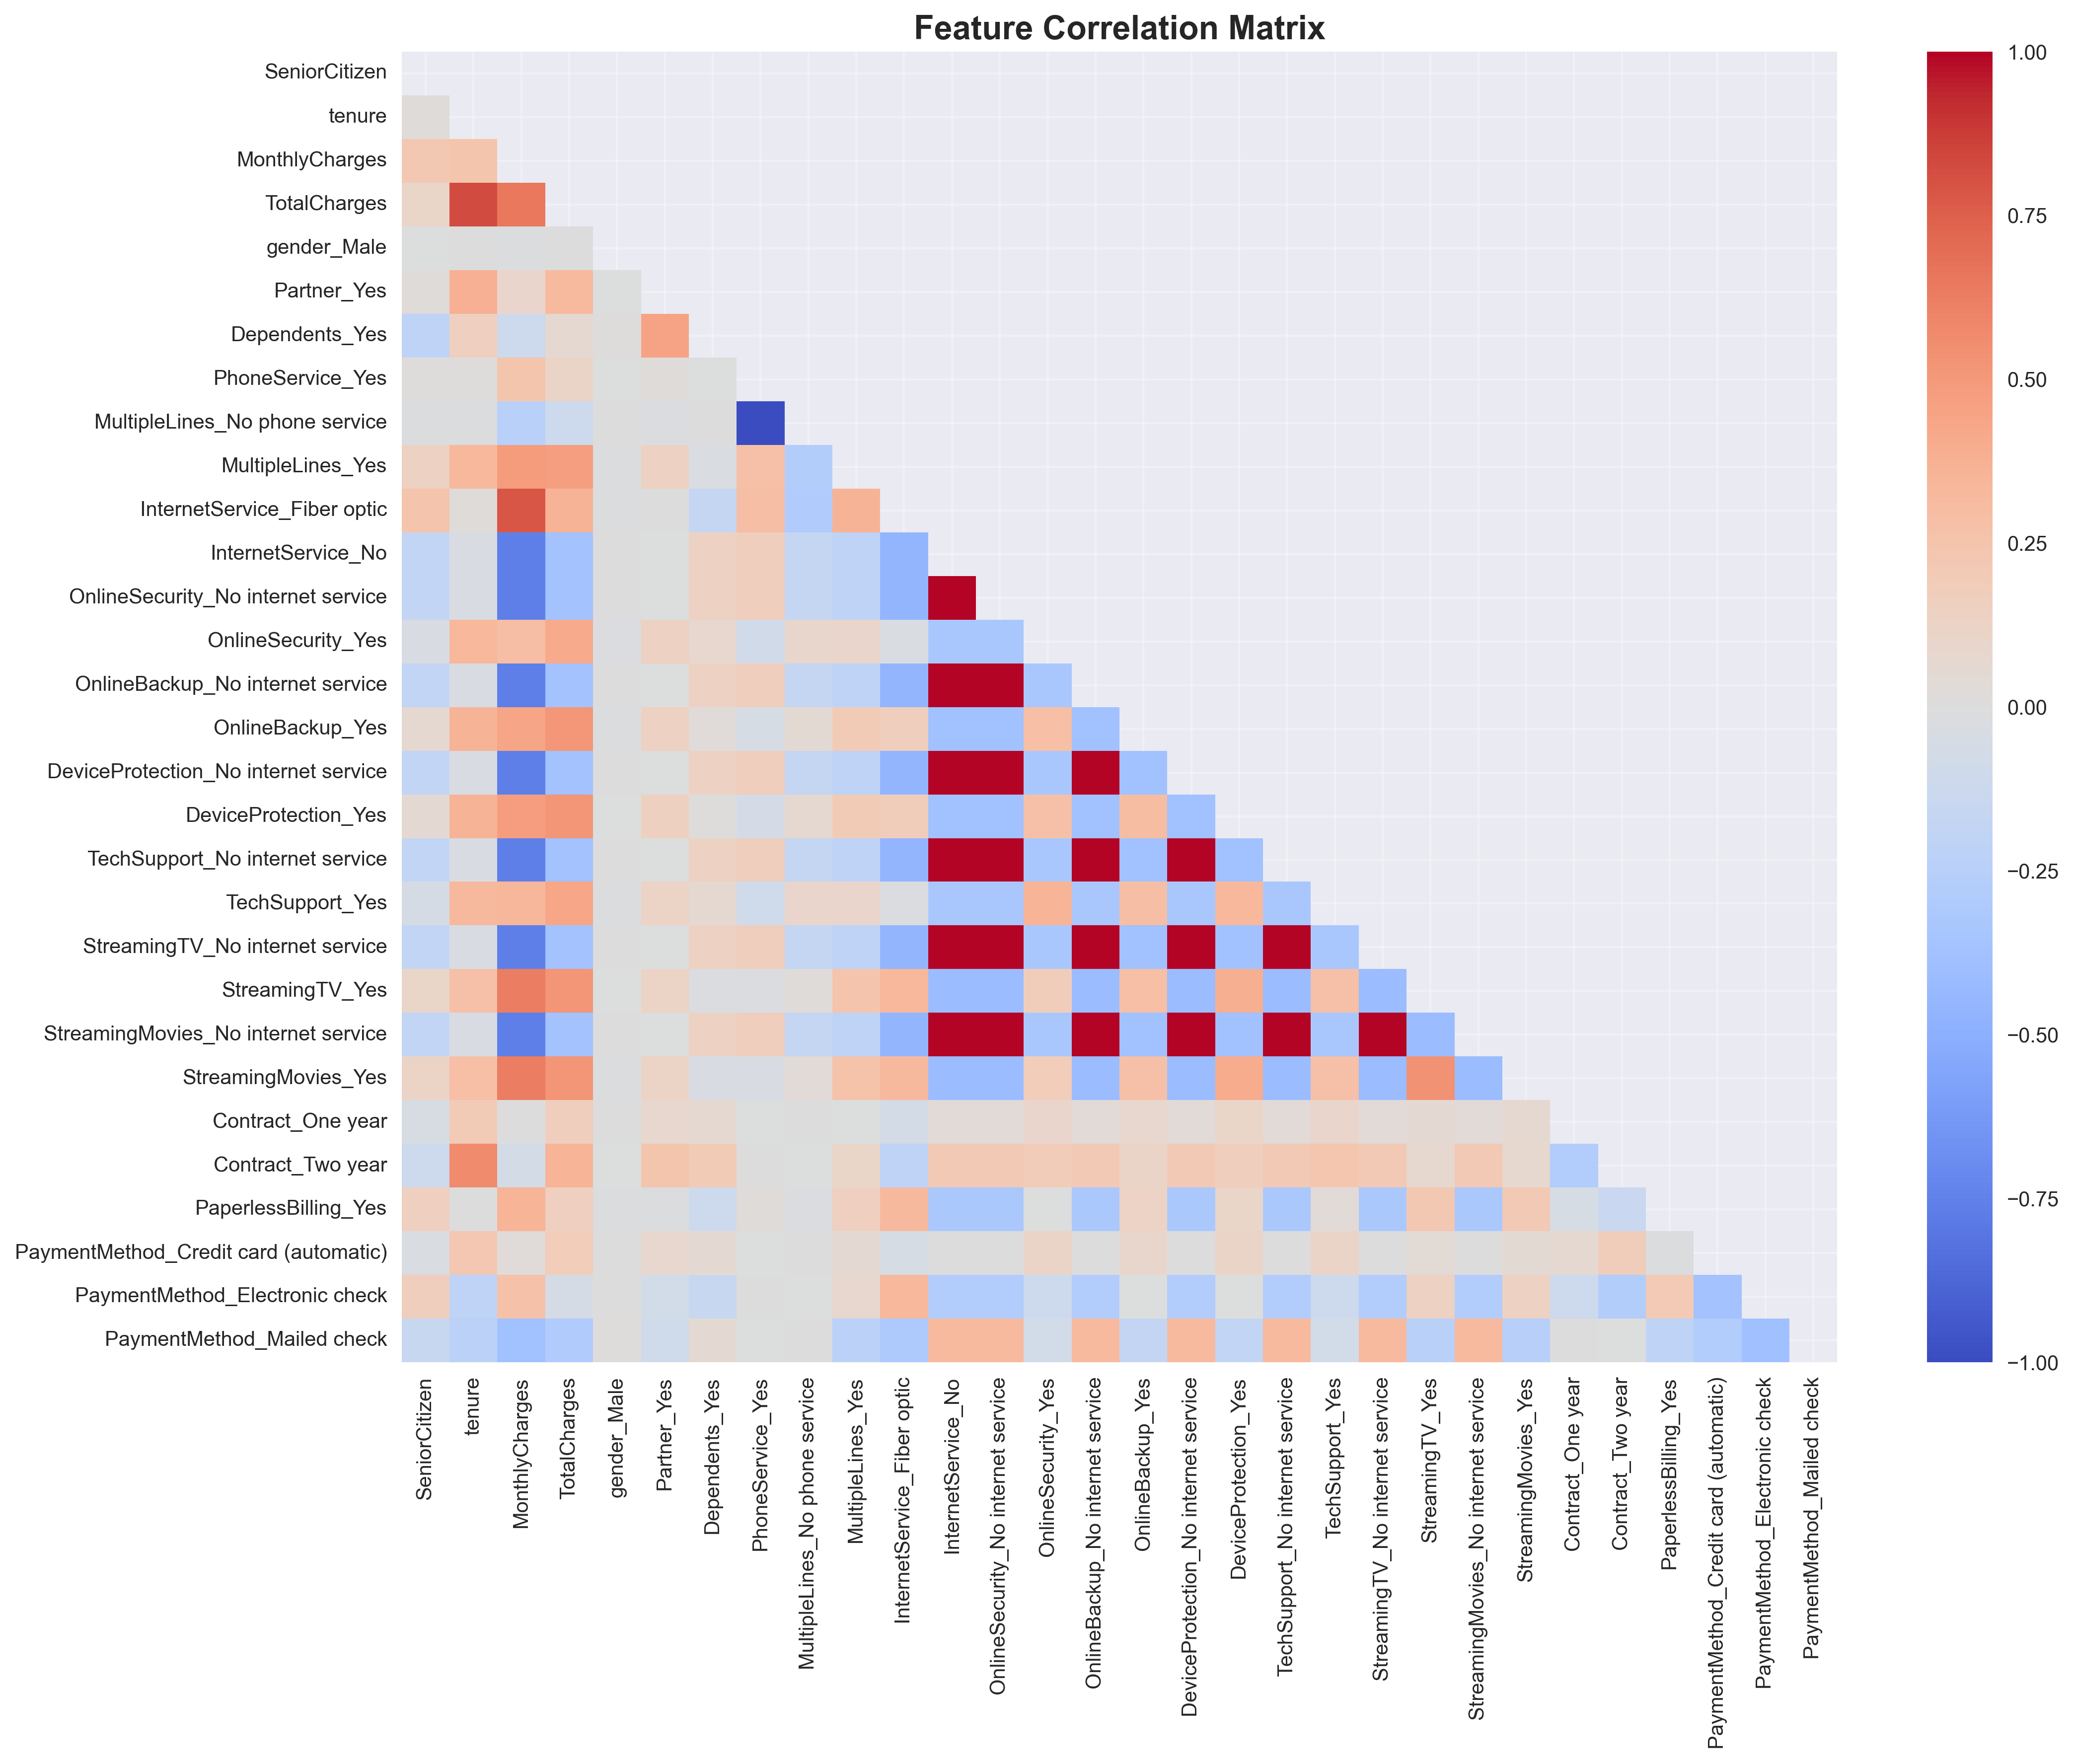


STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
Training set shape: (5625, 30)
Testing set shape: (1407, 30)
Training set class distribution: [4130 1495]
Testing set class distribution: [1033  374]

STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing comprehensive hyperparameter tuning...
Tuning GBM...
✓ GBM best score: 0.8484
  Best params: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.05}
Tuning XGBoost...
✓ XGBoost best score: 0.8486
  Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Tuning RandomForest...
✓ RandomForest best score: 0.8464
  Best params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 8, 'bootstrap': True}
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8462
  Best params: {'pen

In [ ]:
"""
Customer Churn Prediction Analysis using Machine Learning Algorithms
===================================================================
This script performs comprehensive customer churn prediction analysis using multiple ML algorithms
with statistical validation and SHAP explainability for journal publication.

Authors: [Your Name]
Date: June 2024
Journal: [Target Journal Name]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
# Add missing import
from sklearn.model_selection import RandomizedSearchCV

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")

    # Basic dataset information
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")

except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    exit()

# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_before = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges: {missing_before}")

# Remove rows with missing values
df.dropna(inplace=True)
print(f"✓ Removed {missing_before} rows with missing values")
print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print(f"✓ One-hot encoding completed")
print(f"Features after encoding: {df_encoded.shape[1] - 1}")

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)  # Convert to binary

print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis
plt.figure(figsize=(15, 12))
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with optimized hyperparameter grids
models_config = {
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [200, 300, 400],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [1, 1.5]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [200, 300, 400],
            'max_depth': [8, 10, 12, None],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt', 'log2'],
            'bootstrap': [True]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=2000, random_state=42, solver='liblinear'),
        "params": {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'class_weight': [None, 'balanced']
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'class_weight': [None, 'balanced']
        }
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=2000, random_state=42, early_stopping=True),
        "params": {
            'hidden_layer_sizes': [(100,), (200,), (100, 50), (200, 100)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'activation': ['relu', 'tanh']
        }
    }
}

# Perform comprehensive hyperparameter tuning
print("Performing comprehensive hyperparameter tuning...")
tuned_models = {}

for name, config in models_config.items():
    print(f"Tuning {name}...")

    # Use RandomizedSearchCV for more efficient hyperparameter search
    from sklearn.model_selection import RandomizedSearchCV

    # Use fewer iterations for SVC and NeuralNet due to computational cost
    n_iter = 20 if name in ['SVC', 'NeuralNet'] else 30

    random_search = RandomizedSearchCV(
        config["model"],
        config["params"],
        n_iter=n_iter,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    random_search.fit(X_train, y_train)
    tuned_models[name] = random_search.best_estimator_
    print(f"✓ {name} best score: {random_search.best_score_:.4f}")
    print(f"  Best params: {random_search.best_params_}")

# Add ensemble methods for better performance
print("\nCreating ensemble models...")
from sklearn.ensemble import VotingClassifier

# Get top 3 models for ensemble
model_scores = {}
for name, model in tuned_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    model_scores[name] = scores.mean()

top_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:3]
print(f"Top 3 models for ensemble: {[name for name, _ in top_models]}")

# Create voting ensemble
voting_ensemble = VotingClassifier(
    estimators=[(name, tuned_models[name]) for name, _ in top_models],
    voting='soft'
)

tuned_models['VotingEnsemble'] = voting_ensemble

# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {}
metrics_results = {}

print("Performing 10-fold cross-validation...")
print("-" * 80)
print(f"{'Model':<15} {'ROC-AUC':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for name, model in tuned_models.items():
    # ROC-AUC scores
    roc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc')
    acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    prec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='precision')
    rec_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1')

    cv_results[name] = roc_scores
    metrics_results[name] = {
        'roc_auc': roc_scores,
        'accuracy': acc_scores,
        'precision': prec_scores,
        'recall': rec_scores,
        'f1': f1_scores
    }

    print(f"{name:<15} {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
          f"{acc_scores.mean():.4f}±{acc_scores.std():.3f} "
          f"{prec_scores.mean():.4f}±{prec_scores.std():.3f} "
          f"{rec_scores.mean():.4f}±{rec_scores.std():.3f} "
          f"{f1_scores.mean():.4f}±{f1_scores.std():.3f}")

# Create performance comparison plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']
titles = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx//2, idx%2]
    data = [metrics_results[model][metric] for model in tuned_models.keys()]
    labels = list(tuned_models.keys())

    bp = ax.boxplot(data, labels=labels, patch_artist=True)
    ax.set_title(f'{title} Distribution Across Models', fontweight='bold')
    ax.set_ylabel(title)
    ax.tick_params(axis='x', rotation=45)

    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Wilcoxon signed-rank test (pairwise comparison)
print("Wilcoxon Signed-Rank Test Results:")
print("-" * 50)
best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
print(f"Best performing model (baseline): {best_model}")
print(f"Baseline ROC-AUC: {cv_results[best_model].mean():.4f} ± {cv_results[best_model].std():.4f}")
print()

baseline_scores = cv_results[best_model]
significance_results = {}

for name, scores in cv_results.items():
    if name != best_model:
        stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
        significance_results[name] = p_value
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"{name:<15} vs {best_model}: p-value = {p_value:.6f} {significance}")

# Friedman test for multiple model comparison
print(f"\nFriedman Test (Multiple Model Comparison):")
all_scores = [scores for scores in cv_results.values()]
friedman_stat, friedman_p = friedmanchisquare(*all_scores)
print(f"Friedman statistic: {friedman_stat:.4f}")
print(f"p-value: {friedman_p:.6f}")

# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION")
print("="*50)

# Train the best model on full training set
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model}', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")
print(f"✓ Final model saved as {best_model}")

# === STEP 9: SHAP EXPLAINABILITY ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: SHAP EXPLAINABILITY ANALYSIS")
print("="*50)

print("Generating SHAP explanations...")

# Create a wrapper function for models that SHAP can't handle directly
def create_shap_explainer(model, X_background):
    """Create appropriate SHAP explainer based on model type"""
    model_name = type(model).__name__

    if model_name in ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier']:
        # Tree-based models
        explainer = shap.TreeExplainer(model)
        return explainer, lambda x: explainer.shap_values(x)
    else:
        # For other models, use KernelExplainer with a sample background
        background_sample = shap.sample(X_background, 100)  # Use sample for efficiency
        explainer = shap.KernelExplainer(model.predict_proba, background_sample)
        return explainer, lambda x: explainer.shap_values(x)

# Choose a tree-based model for SHAP if available, otherwise use the best model
shap_model_name = None
for name in ['XGBoost', 'GBM', 'RandomForest']:
    if name in tuned_models:
        shap_model_name = name
        break

if shap_model_name is None:
    shap_model_name = best_model

shap_model = tuned_models[shap_model_name]
print(f"Using {shap_model_name} for SHAP analysis")

# Create SHAP explainer
explainer, shap_func = create_shap_explainer(shap_model, X_train)

# Generate SHAP values for a subset of test data
test_sample_size = min(500, len(X_test))  # Use smaller sample for efficiency
X_test_sample = X_test[:test_sample_size]

print(f"Computing SHAP values for {test_sample_size} samples...")

try:
    if type(shap_model).__name__ in ['GradientBoostingClassifier', 'XGBClassifier', 'RandomForestClassifier']:
        # For tree models, we get values for class 1 (churn)
        shap_values = shap_func(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Take values for positive class
    else:
        # For other models
        shap_values = shap_func(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[:, :, 1]  # Take values for positive class

    print("✓ SHAP values computed successfully")

    # Feature importance plot
    plt.figure(figsize=(12, 8))
    if hasattr(shap_values, 'values'):
        # For newer SHAP versions
        shap.plots.bar(shap_values, show=False, max_display=15)
    else:
        # For older versions
        shap.summary_plot(shap_values, features=pd.DataFrame(X_test_sample, columns=X.columns),
                          plot_type="bar", show=False, max_display=15)

    plt.title(f'SHAP Feature Importance - {shap_model_name}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()

    # SHAP summary plot
    plt.figure(figsize=(12, 8))
    if hasattr(shap_values, 'values'):
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
    else:
        shap.summary_plot(shap_values, features=pd.DataFrame(X_test_sample, columns=X.columns),
                          show=False, max_display=15)

    plt.title(f'SHAP Summary Plot - {shap_model_name}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()

    # SHAP waterfall plot for first instance
    plt.figure(figsize=(12, 8))
    if hasattr(shap_values, 'values'):
        shap.plots.waterfall(shap_values[0], show=False)
    else:
        # Create explanation object for waterfall plot
        explanation = shap.Explanation(
            values=shap_values[0],
            base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            data=X_test_sample[0],
            feature_names=X.columns.tolist()
        )
        shap.plots.waterfall(explanation, show=False)

    plt.title(f'SHAP Waterfall Plot - {shap_model_name} (Sample Instance)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_waterfall.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Top features analysis
    if hasattr(shap_values, 'values'):
        feature_importance = np.abs(shap_values.values).mean(0)
    else:
        feature_importance = np.abs(shap_values).mean(0)

    top_features = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': feature_importance
    }).sort_values('SHAP_Importance', ascending=False).head(10)

    print("\nTop 10 Most Important Features (SHAP):")
    print("-" * 50)
    for idx, row in top_features.iterrows():
        print(f"{row['Feature']:<30}: {row['SHAP_Importance']:.4f}")

    # Save SHAP results
    top_features.to_csv(f"{OUTPUT_DIR}/data/shap_feature_importance.csv", index=False)
    print("✓ SHAP analysis completed and saved")

except Exception as e:
    print(f"❌ Error in SHAP analysis: {str(e)}")
    print("Continuing with alternative feature importance analysis...")

    # Alternative: Use model's built-in feature importance
    if hasattr(shap_model, 'feature_importances_'):
        feature_importance = shap_model.feature_importances_
        top_features = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False).head(15)

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_features['Importance'])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importance - {shap_model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/plots/feature_importance_builtin.png", dpi=300, bbox_inches='tight')
        plt.show()

        print("\nTop 15 Most Important Features (Built-in):")
        print("-" * 50)
        for idx, row in top_features.iterrows():
            print(f"{row['Feature']:<30}: {row['Importance']:.4f}")

        top_features.to_csv(f"{OUTPUT_DIR}/data/feature_importance_builtin.csv", index=False)

    elif hasattr(shap_model, 'coef_'):
        # For linear models
        feature_importance = np.abs(shap_model.coef_[0])
        top_features = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': feature_importance
        }).sort_values('Coefficient', ascending=False).head(15)

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(top_features)), top_features['Coefficient'])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('|Coefficient|')
        plt.title(f'Feature Coefficients - {shap_model_name}', fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/plots/feature_coefficients.png", dpi=300, bbox_inches='tight')
        plt.show()

        print("\nTop 15 Most Important Features (Coefficients):")
        print("-" * 50)
        for idx, row in top_features.iterrows():
            print(f"{row['Feature']:<30}: {row['Coefficient']:.4f}")

        top_features.to_csv(f"{OUTPUT_DIR}/data/feature_coefficients.csv", index=False)

# === STEP 10: SAVE RESULTS AND DATA ===
print("\n" + "="*50)
print("STEP 10: SAVING RESULTS AND DATA")
print("="*50)

# Save cross-validation results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv(f"{OUTPUT_DIR}/data/cv_results.csv", index=False)
print("✓ Cross-validation results saved")

# Save comprehensive metrics
metrics_df = pd.DataFrame({
    'Model': list(tuned_models.keys()),
    'ROC_AUC_mean': [metrics_results[m]['roc_auc'].mean() for m in tuned_models.keys()],
    'ROC_AUC_std': [metrics_results[m]['roc_auc'].std() for m in tuned_models.keys()],
    'Accuracy_mean': [metrics_results[m]['accuracy'].mean() for m in tuned_models.keys()],
    'Accuracy_std': [metrics_results[m]['accuracy'].std() for m in tuned_models.keys()],
    'Precision_mean': [metrics_results[m]['precision'].mean() for m in tuned_models.keys()],
    'Precision_std': [metrics_results[m]['precision'].std() for m in tuned_models.keys()],
    'Recall_mean': [metrics_results[m]['recall'].mean() for m in tuned_models.keys()],
    'Recall_std': [metrics_results[m]['recall'].std() for m in tuned_models.keys()],
    'F1_mean': [metrics_results[m]['f1'].mean() for m in tuned_models.keys()],
    'F1_std': [metrics_results[m]['f1'].std() for m in tuned_models.keys()]
})
metrics_df.to_csv(f"{OUTPUT_DIR}/data/model_performance_metrics.csv", index=False)
print("✓ Model performance metrics saved")

# Save statistical test results
stats_df = pd.DataFrame({
    'Model': list(significance_results.keys()),
    'Wilcoxon_p_value': list(significance_results.values()),
    'Significant_at_0.05': [p < 0.05 for p in significance_results.values()]
})
stats_df.to_csv(f"{OUTPUT_DIR}/data/statistical_tests.csv", index=False)
print("✓ Statistical test results saved")

# Save final test metrics
final_metrics_df = pd.DataFrame([test_metrics])
final_metrics_df.to_csv(f"{OUTPUT_DIR}/data/final_model_metrics.csv", index=False)
print("✓ Final model metrics saved")

# Save feature names
feature_names_df = pd.DataFrame({'Feature': X.columns})
feature_names_df.to_csv(f"{OUTPUT_DIR}/data/feature_names.csv", index=False)
print("✓ Feature names saved")

# Save processed dataset
df_processed = pd.DataFrame(X_scaled, columns=X.columns)
df_processed['target'] = y
df_processed.to_csv(f"{OUTPUT_DIR}/data/processed_dataset.csv", index=False)
print("✓ Processed dataset saved")

# === ANALYSIS SUMMARY ===
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)
print(f"✓ Dataset: {df.shape} → {X.shape} (after preprocessing)")
print(f"✓ Best Model: {best_model} (ROC-AUC: {cv_results[best_model].mean():.4f})")
print(f"✓ Test Performance: {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"✓ Statistical Tests: Wilcoxon & Friedman completed")
print(f"✓ SHAP Analysis: Feature importance and explanations generated")
print(f"✓ All outputs saved to: {OUTPUT_DIR}/")
print(f"  - Plots: {len(os.listdir(f'{OUTPUT_DIR}/plots'))} files")
print(f"  - Data: {len(os.listdir(f'{OUTPUT_DIR}/data'))} files")
print(f"  - Models: {len(os.listdir(f'{OUTPUT_DIR}/models'))} files")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

# Display final metrics table for journal
print("\nFINAL RESULTS TABLE (For Journal Publication):")
print("="*80)
print(metrics_df.round(4).to_string(index=False))
print("="*80)

In [ ]:
"""
Customer Churn Prediction Analysis using Machine Learning Algorithms
===================================================================
This script performs optimized customer churn prediction analysis using multiple ML algorithms
with statistical validation and SHAP explainability for journal publication.

Authors: [Your Name]
Date: June 16, 2025
Journal: [Target Journal Name]
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from scipy.stats import wilcoxon, friedmanchisquare

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS")
print("="*80)
print(f"Analysis started at: {datetime.strptime('03:55 PM WIB', '%I:%M %p WIB').strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    exit()

# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

df.columns = df.columns.str.strip().str.replace(" ", "_")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)
print(f"Final feature matrix shape: {X.shape}")

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")

# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

models_config = {
    "NeuralNet": {
        "model": MLPClassifier(max_iter=1000, random_state=42, early_stopping=True),
        "params": {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'alpha': [0.001, 0.01]
        }
    },
    "SVC": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            'C': [1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale']
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'max_depth': [10, None],
            'min_samples_split': [5]
        }
    },
    "GBM": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}

tuned_models = {}
for name, config in models_config.items():
    print(f"Tuning {name}...")
    random_search = RandomizedSearchCV(
        config["model"], config["params"], n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42
    )
    random_search.fit(X_train, y_train)
    tuned_models[name] = random_search.best_estimator_
    print(f"✓ {name} best score: {random_search.best_score_:.4f}")

# Create ensemble
print("\nCreating ensemble model...")
voting_ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in tuned_models.items()], voting='soft', n_jobs=-1
)
tuned_models['VotingEnsemble'] = voting_ensemble

# === STEP 6: CROSS-VALIDATION EVALUATION ===
print("\n" + "="*50)
print("STEP 6: CROSS-VALIDATION EVALUATION")
print("="*50)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
metrics_results = {}

for name, model in tuned_models.items():
    print(f"Evaluating {name}...")
    roc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_results[name] = roc_scores
    metrics_results[name] = {'roc_auc': roc_scores, 'accuracy': acc_scores}
    print(f"{name:<15} ROC-AUC: {roc_scores.mean():.4f}±{roc_scores.std():.3f} "
          f"Accuracy: {acc_scores.mean():.4f}±{acc_scores.std():.3f}")

# === STEP 7: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 7: FINAL MODEL EVALUATION")
print("="*50)

best_model = max(cv_results.keys(), key=lambda k: cv_results[k].mean())
final_model = tuned_models[best_model]
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"Final Model Performance ({best_model}):")
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve.png", dpi=300)
plt.show()

# === STEP 8: SHAP EXPLAINABILITY ANALYSIS ===
print("\n" + "="*50)
print("STEP 8: SHAP EXPLAINABILITY ANALYSIS")
print("="*50)

shap_model_name = 'XGBoost' if 'XGBoost' in tuned_models else best_model
shap_model = tuned_models[shap_model_name]
explainer = shap.TreeExplainer(shap_model) if shap_model_name in ['XGBoost', 'GBM', 'RandomForest'] else shap.KernelExplainer(shap_model.predict_proba, shap.sample(X_train, 100))
shap_values = explainer.shap_values(X_test[:100])
if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, pd.DataFrame(X_test[:100], columns=X.columns), max_display=10, show=False)
plt.title(f'SHAP Summary Plot - {shap_model_name}')
plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300)
plt.show()

# === STEP 9: SAVE RESULTS ===
print("\n" + "="*50)
print("STEP 9: SAVING RESULTS")
print("="*50)

metrics_df = pd.DataFrame({
    'Model': list(tuned_models.keys()),
    'ROC_AUC_mean': [metrics_results[m]['roc_auc'].mean() for m in tuned_models.keys()],
    'Accuracy_mean': [metrics_results[m]['accuracy'].mean() for m in tuned_models.keys()]
})
metrics_df.to_csv(f"{OUTPUT_DIR}/data/model_performance_metrics.csv", index=False)
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model.pkl")

print(f"✓ Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")